In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate
import distributions.priors as priors
import getdist
from getdist import plots, MCSamples
import ndes.ndes as ndes
import delfi.delfi as delfi
import tensorflow as tf
import simulators.cosmic_shear.cosmic_shear as cosmic_shear
import pickle
import compression.score.score as score
%matplotlib inline

In [2]:
### SET UP THE SIMULATOR ###

# Set up the tomography simulations
pz = pickle.load(open('simulators/cosmic_shear/pz_euclid.pkl', 'rb'))
CosmicShearSimulator = cosmic_shear.TomographicCosmicShear(pz = pz, lmin = 10, lmax = 3000, n_ell_bins = 10, 
                                                           sigma_e = 0.3, nbar = 30, Area = 15000)

# Simulator function: This must be of the form simulator(theta, seed, args) -> simulated data vector
def simulator(theta, seed, simulator_args):
    return CosmicShearSimulator.simulate(theta, seed)
simulator_args = None

In [3]:
### SET UP THE PRIOR ###

# Define the priors parameters
lower = np.array([0, 0.4, 0, 0.4, 0.7])
upper = np.array([1, 1.2, 0.1, 1.0, 1.3])
prior_mean = np.array([0.3, 0.8, 0.05, 0.70, 0.96])
prior_covariance = np.eye(5)*np.array([0.1, 0.1, 0.05, 0.3, 0.3])**2

# Prior
prior = priors.TruncatedGaussian(prior_mean, prior_covariance, lower, upper)

In [4]:
### SET UP THE COMPRESSOR ###

# Fiducial parameters
theta_fiducial = np.array([0.3, 0.8, 0.05, 0.70, 0.96])

# Expected support of Wishart likelihood (fiducial inverse power spectrum)
C = CosmicShearSimulator.power_spectrum(theta_fiducial)
Cinv = np.array([np.linalg.inv(C[l,:,:]) for l in range(CosmicShearSimulator.n_ell_bins)])

# Degrees of freedom (effective number of modes per band power)
nl = CosmicShearSimulator.nl

# Calculate derivatives of the expected power spectrum
h = np.array(abs(theta_fiducial)*np.array([0.05, 0.05, 0.05, 0.05, 0.05]))
dCdt = CosmicShearSimulator.compute_derivatives(theta_fiducial, h)

# Define compression as score-MLE of a Wishart likelihood
Compressor = score.Wishart(theta_fiducial, nl, Cinv, dCdt, prior_mean=prior_mean, prior_covariance=prior_covariance)

# Pull out Fisher matrix inverse
Finv = Compressor.Finv

# Compressor function: This must have the form compressor(data, args) -> compressed summaries (pseudoMLE)
def compressor(d, compressor_args):
    return Compressor.scoreMLE(d)
compressor_args = None

In [5]:
### LOAD IN THE DATA VECTOR ###
data = compressor(simulator(theta_fiducial, 0, simulator_args), compressor_args)

In [6]:
# Create the neural density estimator (MAF)
MAF = ndes.ConditionalMaskedAutoregressiveFlow(n_inputs=5, n_outputs=5, n_hiddens=[50,50], 
                                               n_mades=5, act_fun=tf.tanh)

# Create the DELFI object
DelfiMAF = delfi.Delfi(data, prior, MAF, Finv, theta_fiducial, 
                       param_limits = [lower, upper],
                       param_names = ['\Omega_m', 'S_8', '\Omega_b', 'h', 'n_s'], 
                       results_dir = "simulators/cosmic_shear/results/maf")

Generating fisher pre-training data...
Training the neural density estimator...
Epoch 00000, Train_loss: 33.8539, Val_loss: 34.2880
Epoch 00001, Train_loss: 19.7170, Val_loss: 19.8360
Epoch 00002, Train_loss: 17.6883, Val_loss: 17.8064
Epoch 00003, Train_loss: 16.8722, Val_loss: 16.9843
Epoch 00004, Train_loss: 16.1499, Val_loss: 16.2571
Epoch 00005, Train_loss: 15.6221, Val_loss: 15.7002
Epoch 00006, Train_loss: 15.1141, Val_loss: 15.1443
Epoch 00007, Train_loss: 14.7307, Val_loss: 14.7676
Epoch 00008, Train_loss: 14.2896, Val_loss: 14.2932
Epoch 00009, Train_loss: 13.8738, Val_loss: 13.9372
Epoch 00010, Train_loss: 13.4573, Val_loss: 13.4862
Epoch 00011, Train_loss: 12.9139, Val_loss: 12.9896
Epoch 00012, Train_loss: 12.3116, Val_loss: 12.3470
Epoch 00013, Train_loss: 11.5796, Val_loss: 11.6191
Epoch 00014, Train_loss: 11.2781, Val_loss: 11.3285
Epoch 00015, Train_loss: 10.6225, Val_loss: 10.6341
Epoch 00016, Train_loss: 10.4475, Val_loss: 10.4625
Epoch 00017, Train_loss: 9.6825, Val

Epoch 00162, Train_loss: 4.2612, Val_loss: 4.3380
Epoch 00163, Train_loss: 4.1295, Val_loss: 4.2285
Epoch 00164, Train_loss: 4.2975, Val_loss: 4.3831
Epoch 00165, Train_loss: 4.0930, Val_loss: 4.1813
Epoch 00166, Train_loss: 4.2055, Val_loss: 4.2823
Epoch 00167, Train_loss: 4.2314, Val_loss: 4.3382
Epoch 00168, Train_loss: 4.2444, Val_loss: 4.3091
Epoch 00169, Train_loss: 4.3203, Val_loss: 4.3949
Epoch 00170, Train_loss: 4.8282, Val_loss: 4.9331
Epoch 00171, Train_loss: 4.1319, Val_loss: 4.2355
Epoch 00172, Train_loss: 4.1882, Val_loss: 4.2837
Epoch 00173, Train_loss: 4.1168, Val_loss: 4.2113
Epoch 00174, Train_loss: 4.0808, Val_loss: 4.1771
Epoch 00175, Train_loss: 4.0519, Val_loss: 4.1527
Epoch 00176, Train_loss: 4.1899, Val_loss: 4.2840
Epoch 00177, Train_loss: 3.9316, Val_loss: 4.0082
Epoch 00178, Train_loss: 4.0387, Val_loss: 4.1312
Epoch 00179, Train_loss: 4.0629, Val_loss: 4.1414
Epoch 00180, Train_loss: 4.2965, Val_loss: 4.3987
Epoch 00181, Train_loss: 4.0661, Val_loss: 4.1473


Epoch 00326, Train_loss: 3.9576, Val_loss: 4.0892
Epoch 00327, Train_loss: 3.9819, Val_loss: 4.1078
Epoch 00328, Train_loss: 4.0918, Val_loss: 4.2397
Epoch 00329, Train_loss: 3.9757, Val_loss: 4.0865
Epoch 00330, Train_loss: 4.2019, Val_loss: 4.2933
Epoch 00331, Train_loss: 4.1334, Val_loss: 4.2505
Epoch 00332, Train_loss: 3.9659, Val_loss: 4.0917
Epoch 00333, Train_loss: 4.0449, Val_loss: 4.1719
Epoch 00334, Train_loss: 3.9493, Val_loss: 4.0541
Epoch 00335, Train_loss: 4.0336, Val_loss: 4.1531
Epoch 00336, Train_loss: 3.9282, Val_loss: 4.0359
Epoch 00337, Train_loss: 4.0770, Val_loss: 4.1766
Epoch 00338, Train_loss: 3.9519, Val_loss: 4.0691
Epoch 00339, Train_loss: 4.2008, Val_loss: 4.3267
Epoch 00340, Train_loss: 3.9170, Val_loss: 4.0315
Epoch 00341, Train_loss: 3.9059, Val_loss: 4.0413
Epoch 00342, Train_loss: 3.9839, Val_loss: 4.1189
Epoch 00343, Train_loss: 4.1660, Val_loss: 4.2991
Epoch 00344, Train_loss: 4.0542, Val_loss: 4.2042
Epoch 00345, Train_loss: 4.2054, Val_loss: 4.3206


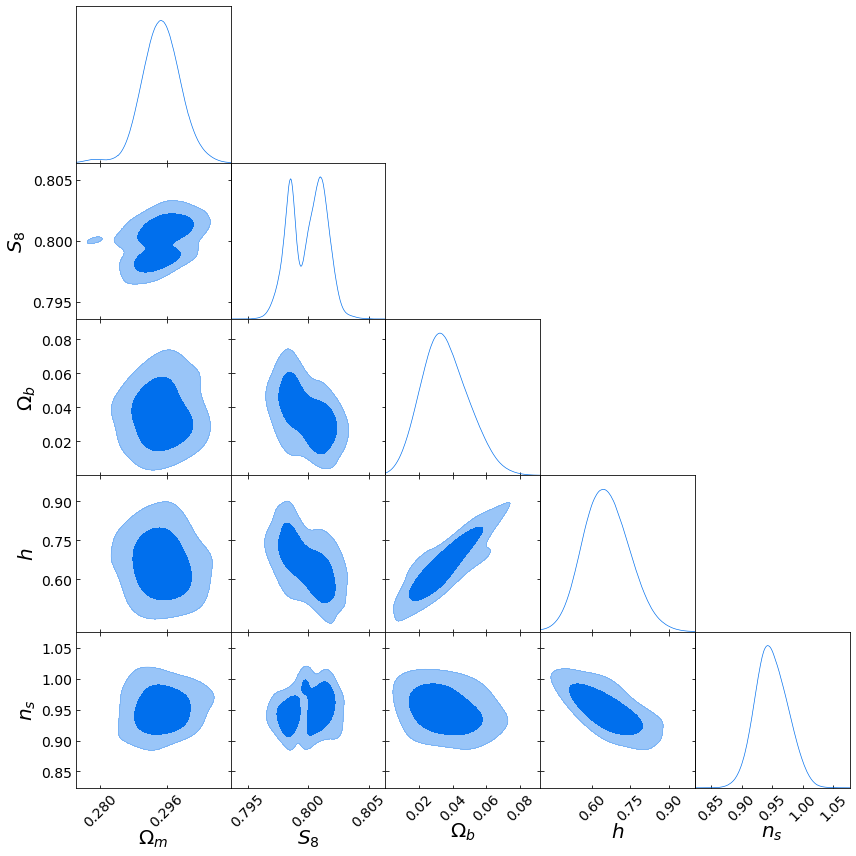

In [7]:
# Do the Fisher pre-training
DelfiMAF.fisher_pretraining(50000, prior, epochs=500, patience=100)

Running initial 500 sims...
Done.
Epoch 00000, Train_loss: 7.4503, Val_loss: 7.7909
Epoch 00001, Train_loss: 7.0013, Val_loss: 6.9427
Epoch 00002, Train_loss: 6.5891, Val_loss: 6.6840
Epoch 00003, Train_loss: 6.2657, Val_loss: 6.3412
Epoch 00004, Train_loss: 5.9225, Val_loss: 6.0965
Epoch 00005, Train_loss: 5.7046, Val_loss: 6.0196
Epoch 00006, Train_loss: 5.5566, Val_loss: 5.8544
Epoch 00007, Train_loss: 5.4078, Val_loss: 5.7975
Epoch 00008, Train_loss: 5.3123, Val_loss: 5.7310
Epoch 00009, Train_loss: 5.2027, Val_loss: 5.5655
Epoch 00010, Train_loss: 5.1171, Val_loss: 5.6302
Epoch 00011, Train_loss: 5.0375, Val_loss: 5.4667
Epoch 00012, Train_loss: 4.9590, Val_loss: 5.5056
Epoch 00013, Train_loss: 4.8984, Val_loss: 5.4190
Epoch 00014, Train_loss: 4.8273, Val_loss: 5.3290
Epoch 00015, Train_loss: 4.7543, Val_loss: 5.3382
Epoch 00016, Train_loss: 4.6816, Val_loss: 5.2361
Epoch 00017, Train_loss: 4.6294, Val_loss: 5.2581
Epoch 00018, Train_loss: 4.5582, Val_loss: 5.1582
Epoch 00019, Tra

INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/maftmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results/mafseq_train_post_0.pdf


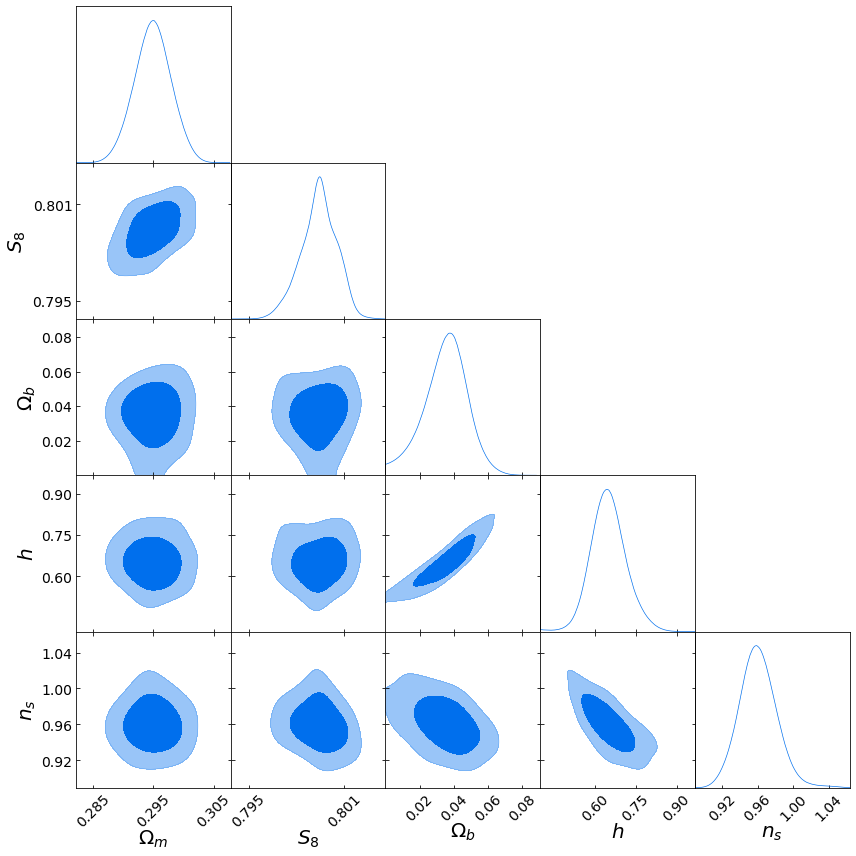

Population 1/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 3.8634, Val_loss: 4.3142
Epoch 00001, Train_loss: 3.7666, Val_loss: 4.3145
Epoch 00002, Train_loss: 3.6910, Val_loss: 4.1839
Epoch 00003, Train_loss: 3.6501, Val_loss: 4.2342
Epoch 00004, Train_loss: 3.6772, Val_loss: 4.2638
Epoch 00005, Train_loss: 3.7155, Val_loss: 4.3383
Epoch 00006, Train_loss: 3.6630, Val_loss: 4.1757
Epoch 00007, Train_loss: 3.6262, Val_loss: 4.1763
Epoch 00008, Train_loss: 3.5562, Val_loss: 4.2886
Epoch 00009, Train_loss: 3.5485, Val_loss: 4.2974
Epoch 00010, Train_loss: 3.5289, Val_loss: 4.3596
Epoch 00011, Train_loss: 3.4539, Val_loss: 4.2211
Epoch 00012, Train_loss: 3.4654, Val_loss: 4.1782
Epoch 00013, Train_loss: 3.4580, Val_loss: 4.3603
Epoch 00014, Train_loss: 3.4270, Val_loss: 4.2264
Epoch 00015, Train_loss: 3.4284, Val_loss: 4.2503
Epoch 00016, Train_loss: 3.4037, Val_loss: 4.2068
Training finished
Best epoch 00015, Val_loss: 4.1757
INFO:tensorflow:Rest

INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/maftmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results/mafseq_train_post_1.pdf


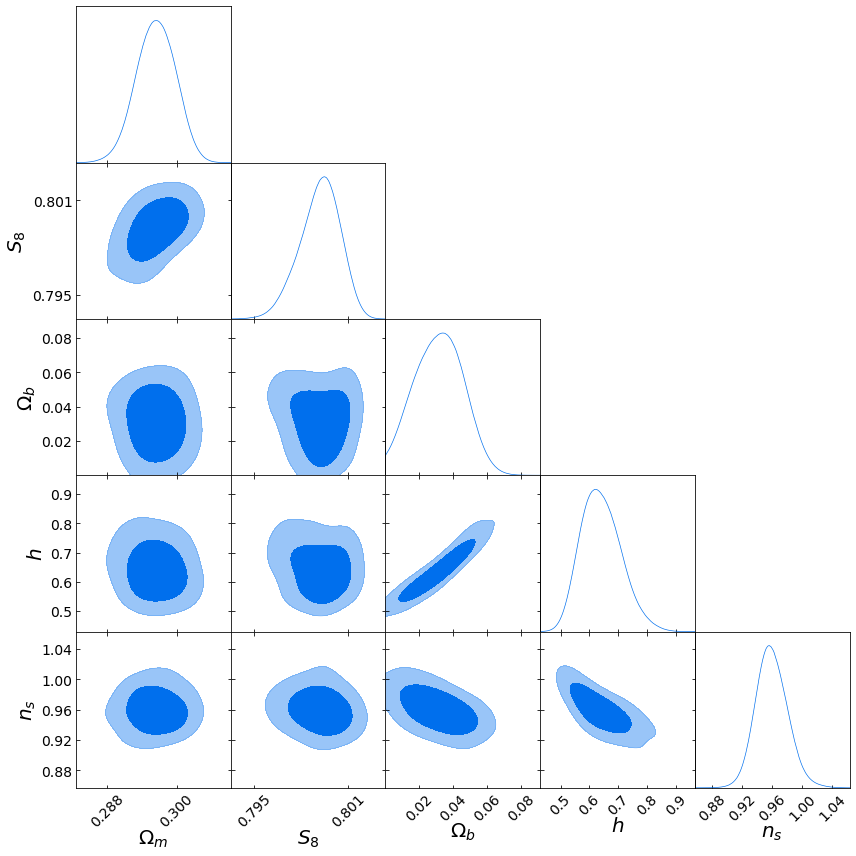

Saving simulators/cosmic_shear/results/mafseq_train_loss.pdf


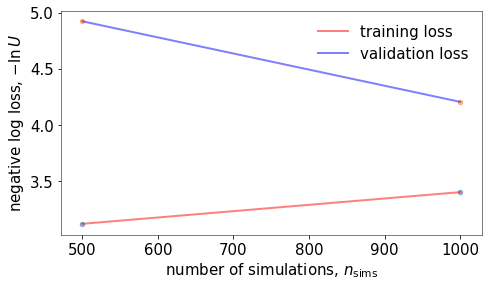

Population 2/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 4.0131, Val_loss: 4.1624
Epoch 00001, Train_loss: 3.8846, Val_loss: 4.0849
Epoch 00002, Train_loss: 3.8199, Val_loss: 4.0252
Epoch 00003, Train_loss: 3.8138, Val_loss: 4.0833
Epoch 00004, Train_loss: 3.8024, Val_loss: 4.0786
Epoch 00005, Train_loss: 3.8016, Val_loss: 4.1027
Epoch 00006, Train_loss: 3.7715, Val_loss: 4.0555
Epoch 00007, Train_loss: 3.7365, Val_loss: 4.0073
Epoch 00008, Train_loss: 3.7658, Val_loss: 4.0670
Epoch 00009, Train_loss: 3.7311, Val_loss: 4.0292
Epoch 00010, Train_loss: 3.6876, Val_loss: 4.0589
Epoch 00011, Train_loss: 3.6868, Val_loss: 4.0030
Epoch 00012, Train_loss: 3.6451, Val_loss: 3.9705
Epoch 00013, Train_loss: 3.6603, Val_loss: 3.9871
Epoch 00014, Train_loss: 3.6465, Val_loss: 3.9751
Epoch 00015, Train_loss: 3.6617, Val_loss: 4.0262
Epoch 00016, Train_loss: 3.6541, Val_loss: 4.0221
Epoch 00017, Train_loss: 3.6800, Val_loss: 4.0462
Epoch 00018, Train_loss

INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/maftmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results/mafseq_train_post_2.pdf


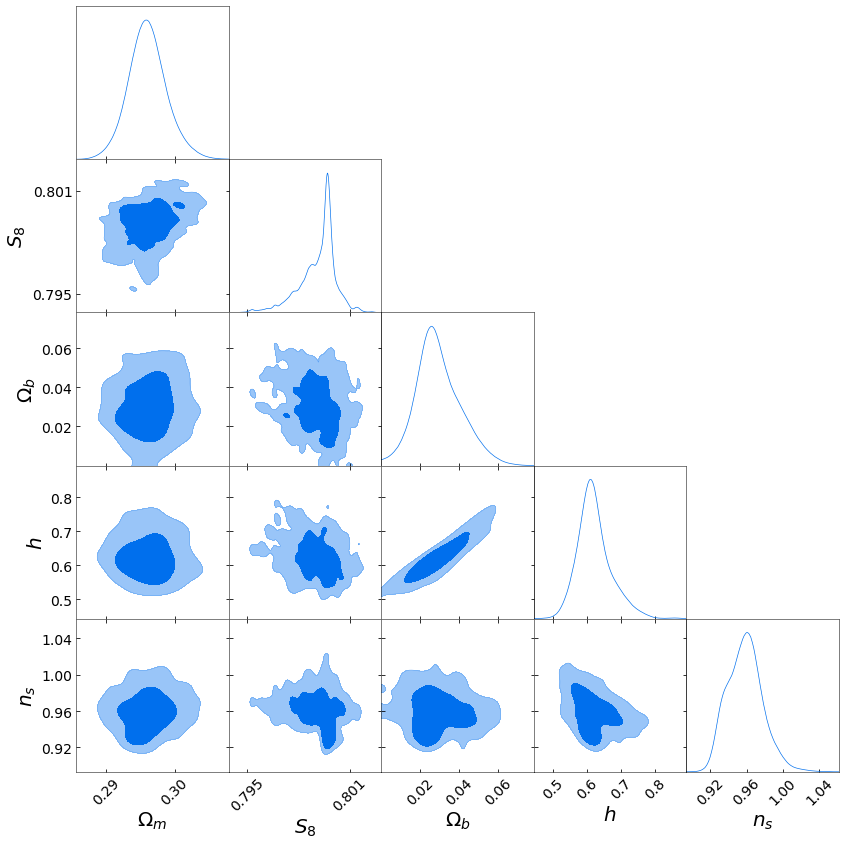

Saving simulators/cosmic_shear/results/mafseq_train_loss.pdf


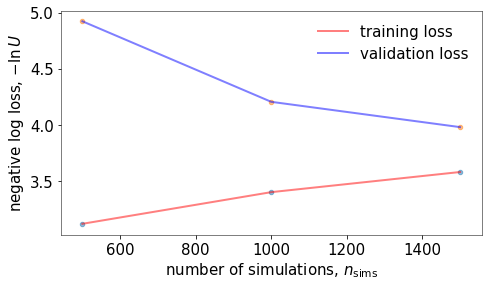

Population 3/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 3.9017, Val_loss: 3.8539
Epoch 00001, Train_loss: 3.8499, Val_loss: 3.8513
Epoch 00002, Train_loss: 3.8433, Val_loss: 3.8810
Epoch 00003, Train_loss: 3.8190, Val_loss: 3.8714
Epoch 00004, Train_loss: 3.8005, Val_loss: 3.8522
Epoch 00005, Train_loss: 3.7854, Val_loss: 3.8834
Epoch 00006, Train_loss: 3.7765, Val_loss: 3.8559
Epoch 00007, Train_loss: 3.7769, Val_loss: 3.8763
Epoch 00008, Train_loss: 3.7381, Val_loss: 3.8317
Epoch 00009, Train_loss: 3.7376, Val_loss: 3.8351
Epoch 00010, Train_loss: 3.7696, Val_loss: 3.8551
Epoch 00011, Train_loss: 3.7687, Val_loss: 3.8946
Epoch 00012, Train_loss: 3.7010, Val_loss: 3.8562
Epoch 00013, Train_loss: 3.7017, Val_loss: 3.8848
Epoch 00014, Train_loss: 3.7153, Val_loss: 3.9031
Epoch 00015, Train_loss: 3.6850, Val_loss: 3.8948
Epoch 00016, Train_loss: 3.7244, Val_loss: 3.9001
Epoch 00017, Train_loss: 3.6750, Val_loss: 3.8590
Epoch 00018, Train_loss

INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/maftmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results/mafseq_train_post_3.pdf


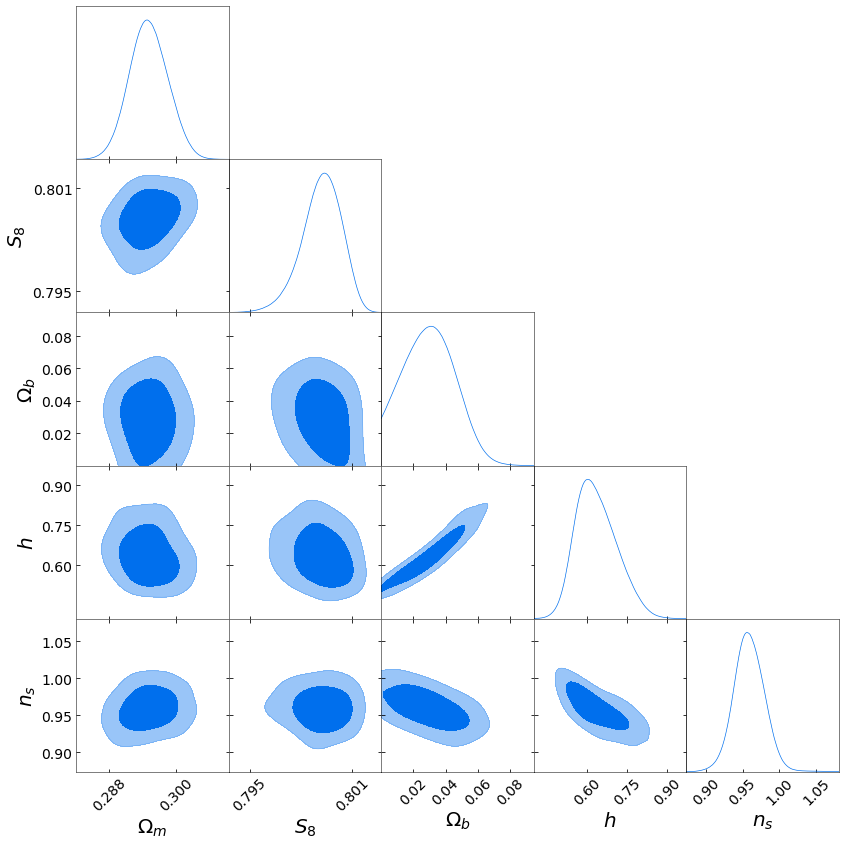

Saving simulators/cosmic_shear/results/mafseq_train_loss.pdf


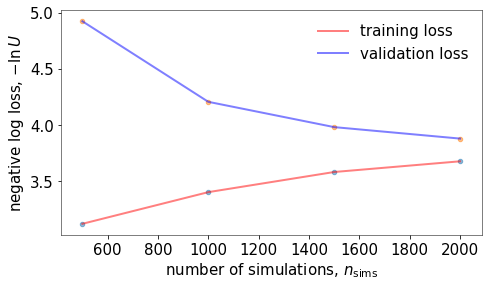

Population 4/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 3.8668, Val_loss: 3.8209
Epoch 00001, Train_loss: 3.8420, Val_loss: 3.8330
Epoch 00002, Train_loss: 3.8170, Val_loss: 3.8126
Epoch 00003, Train_loss: 3.8157, Val_loss: 3.8658
Epoch 00004, Train_loss: 3.8033, Val_loss: 3.8514
Epoch 00005, Train_loss: 3.7941, Val_loss: 3.8813
Epoch 00006, Train_loss: 3.7657, Val_loss: 3.8117
Epoch 00007, Train_loss: 3.7924, Val_loss: 3.8497
Epoch 00008, Train_loss: 3.7978, Val_loss: 3.8921
Epoch 00009, Train_loss: 3.7590, Val_loss: 3.8414
Epoch 00010, Train_loss: 3.7426, Val_loss: 3.8494
Epoch 00011, Train_loss: 3.7397, Val_loss: 3.8632
Epoch 00012, Train_loss: 3.7360, Val_loss: 3.8807
Epoch 00013, Train_loss: 3.7313, Val_loss: 3.8700
Epoch 00014, Train_loss: 3.7188, Val_loss: 3.8992
Epoch 00015, Train_loss: 3.7094, Val_loss: 3.8868
Epoch 00016, Train_loss: 3.6963, Val_loss: 3.8738
Training finished
Best epoch 00015, Val_loss: 3.8117
INFO:tensorflow:Rest

INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/maftmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results/mafseq_train_post_4.pdf


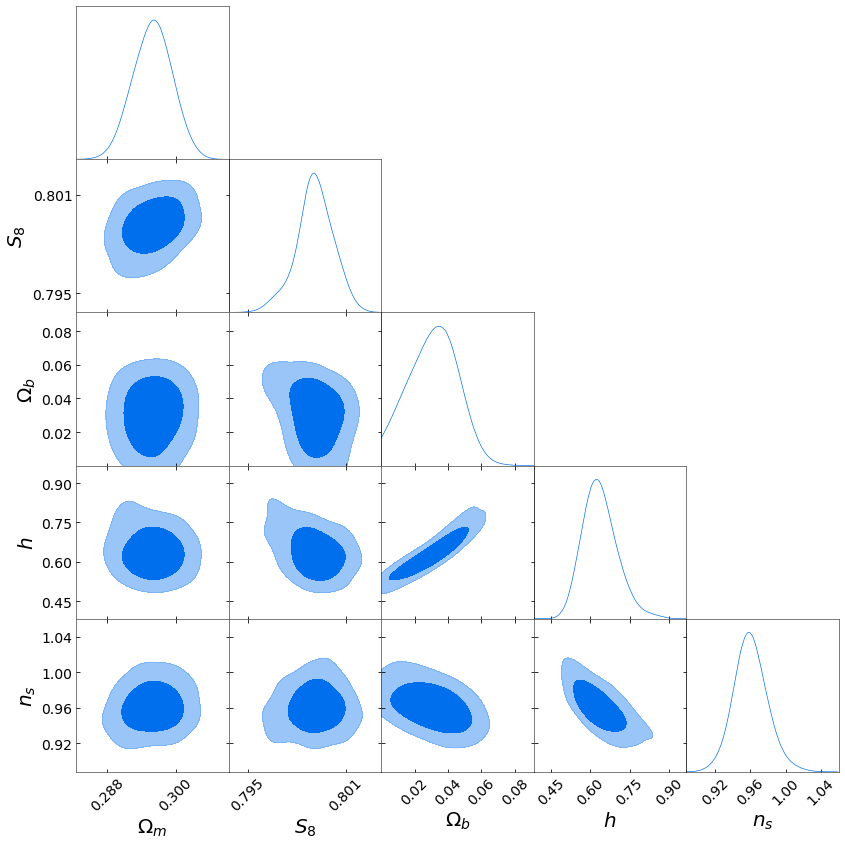

Saving simulators/cosmic_shear/results/mafseq_train_loss.pdf


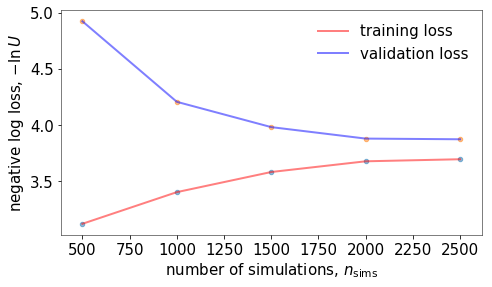

Population 5/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 3.8828, Val_loss: 3.8730
Epoch 00001, Train_loss: 3.8776, Val_loss: 3.9246
Epoch 00002, Train_loss: 3.8550, Val_loss: 3.9116
Epoch 00003, Train_loss: 3.8290, Val_loss: 3.8706
Epoch 00004, Train_loss: 3.8492, Val_loss: 3.8977
Epoch 00005, Train_loss: 3.8351, Val_loss: 3.9367
Epoch 00006, Train_loss: 3.8128, Val_loss: 3.9174
Epoch 00007, Train_loss: 3.7913, Val_loss: 3.8797
Epoch 00008, Train_loss: 3.7831, Val_loss: 3.8686
Epoch 00009, Train_loss: 3.7951, Val_loss: 3.8848
Epoch 00010, Train_loss: 3.7932, Val_loss: 3.8973
Epoch 00011, Train_loss: 3.8112, Val_loss: 3.9710
Epoch 00012, Train_loss: 3.8033, Val_loss: 3.8900
Epoch 00013, Train_loss: 3.8274, Val_loss: 3.9688
Epoch 00014, Train_loss: 3.7462, Val_loss: 3.8698
Epoch 00015, Train_loss: 3.7902, Val_loss: 3.9198
Epoch 00016, Train_loss: 3.7928, Val_loss: 3.9457
Epoch 00017, Train_loss: 3.7480, Val_loss: 3.8684
Epoch 00018, Train_loss

INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/maftmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results/mafseq_train_post_5.pdf


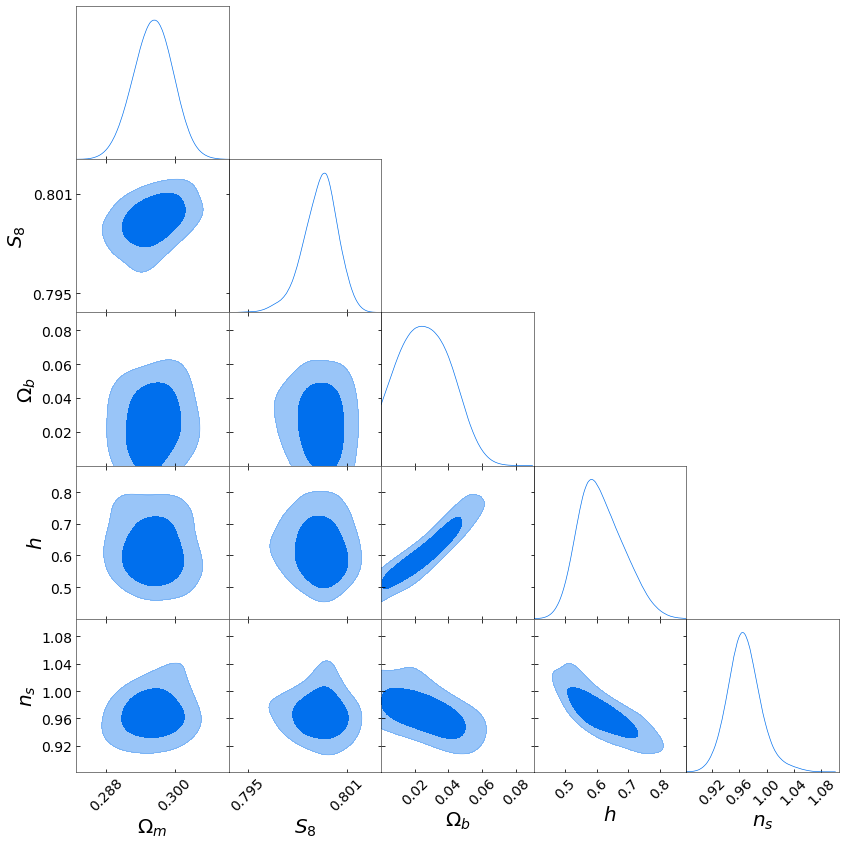

Saving simulators/cosmic_shear/results/mafseq_train_loss.pdf


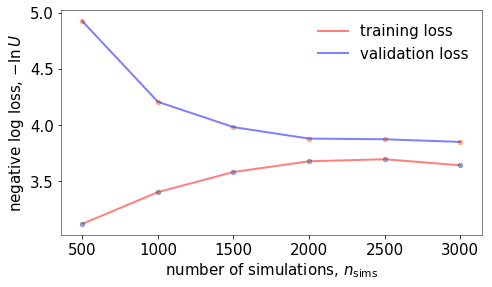

Population 6/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 3.7512, Val_loss: 3.5720
Epoch 00001, Train_loss: 3.7328, Val_loss: 3.5876
Epoch 00002, Train_loss: 3.7428, Val_loss: 3.6040
Epoch 00003, Train_loss: 3.7330, Val_loss: 3.5977
Epoch 00004, Train_loss: 3.6991, Val_loss: 3.5789
Epoch 00005, Train_loss: 3.6897, Val_loss: 3.5958
Epoch 00006, Train_loss: 3.7447, Val_loss: 3.6568
Epoch 00007, Train_loss: 3.7360, Val_loss: 3.6504
Epoch 00008, Train_loss: 3.6909, Val_loss: 3.6095
Epoch 00009, Train_loss: 3.6693, Val_loss: 3.5999
Epoch 00010, Train_loss: 3.6722, Val_loss: 3.6093
Training finished
Best epoch 00009, Val_loss: 3.5720
INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/maftmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/maftmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results/mafseq_train_post_6.pdf


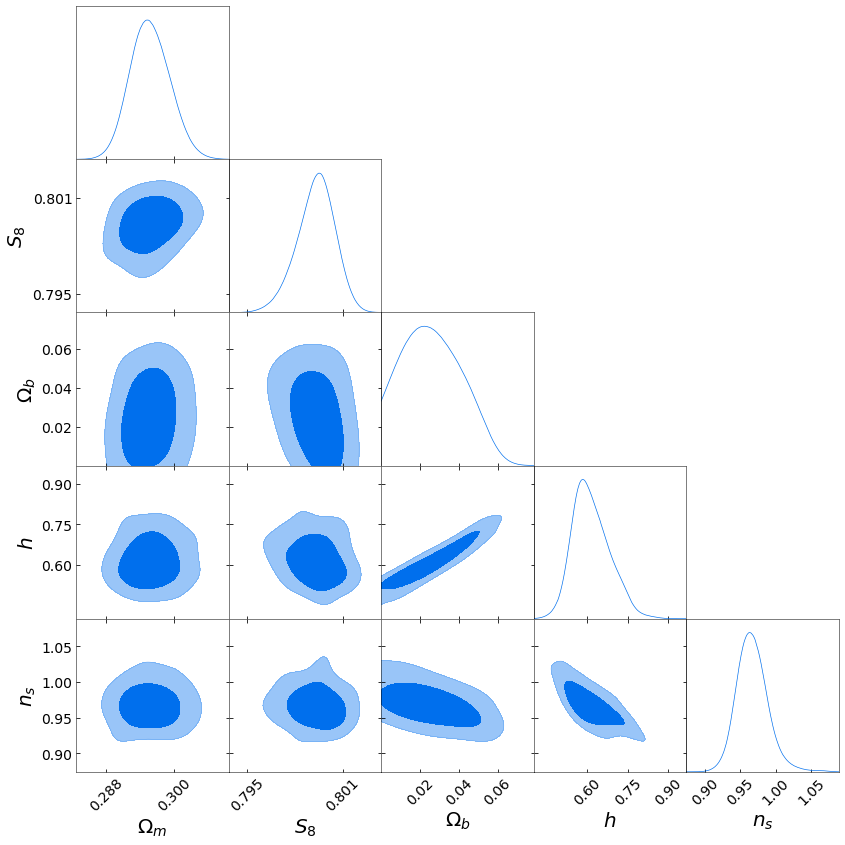

Saving simulators/cosmic_shear/results/mafseq_train_loss.pdf


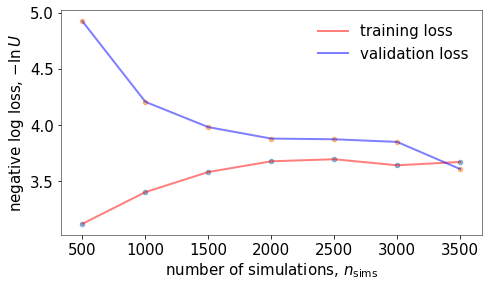

Population 7/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 3.7972, Val_loss: 3.9597
Epoch 00001, Train_loss: 3.7780, Val_loss: 3.9902
Epoch 00002, Train_loss: 3.7638, Val_loss: 3.9852
Epoch 00003, Train_loss: 3.7594, Val_loss: 3.9935
Epoch 00004, Train_loss: 3.7539, Val_loss: 3.9928
Epoch 00005, Train_loss: 3.7413, Val_loss: 4.0011
Epoch 00006, Train_loss: 3.7320, Val_loss: 3.9870
Epoch 00007, Train_loss: 3.7434, Val_loss: 4.0350
Epoch 00008, Train_loss: 3.7385, Val_loss: 4.0159
Epoch 00009, Train_loss: 3.7130, Val_loss: 3.9991
Epoch 00010, Train_loss: 3.7070, Val_loss: 4.0025
Training finished
Best epoch 00009, Val_loss: 3.9597
INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/maftmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/maftmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results/mafseq_train_post_7.pdf


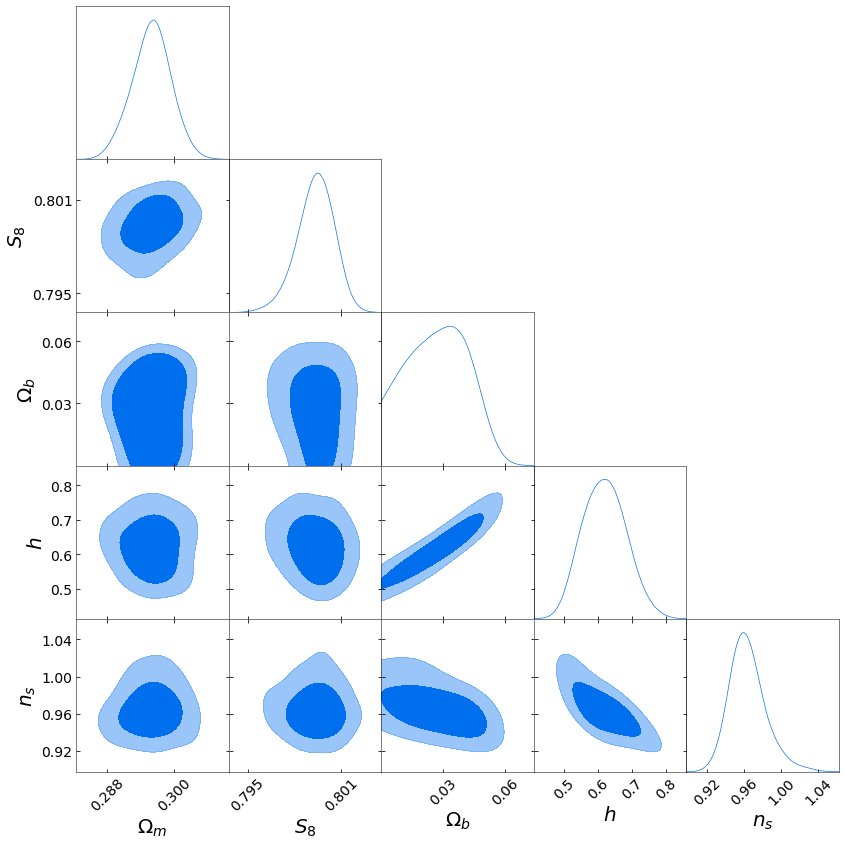

Saving simulators/cosmic_shear/results/mafseq_train_loss.pdf


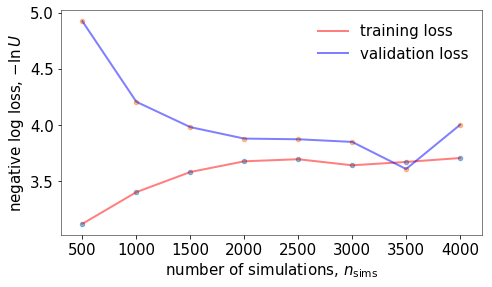

Population 8/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 3.8126, Val_loss: 3.7347
Epoch 00001, Train_loss: 3.8134, Val_loss: 3.7597
Epoch 00002, Train_loss: 3.7922, Val_loss: 3.7571
Epoch 00003, Train_loss: 3.7803, Val_loss: 3.7588
Epoch 00004, Train_loss: 3.7620, Val_loss: 3.7393
Epoch 00005, Train_loss: 3.7562, Val_loss: 3.7408
Epoch 00006, Train_loss: 3.7843, Val_loss: 3.7760
Epoch 00007, Train_loss: 3.7638, Val_loss: 3.7700
Epoch 00008, Train_loss: 3.7218, Val_loss: 3.7422
Epoch 00009, Train_loss: 3.7180, Val_loss: 3.7252
Epoch 00010, Train_loss: 3.7192, Val_loss: 3.7262
Epoch 00011, Train_loss: 3.7160, Val_loss: 3.7422
Epoch 00012, Train_loss: 3.7168, Val_loss: 3.7454
Epoch 00013, Train_loss: 3.7204, Val_loss: 3.7369
Epoch 00014, Train_loss: 3.7384, Val_loss: 3.7698
Epoch 00015, Train_loss: 3.7286, Val_loss: 3.7481
Epoch 00016, Train_loss: 3.7264, Val_loss: 3.7758
Epoch 00017, Train_loss: 3.6861, Val_loss: 3.7393
Epoch 00018, Train_loss

INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/maftmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results/mafseq_train_post_8.pdf


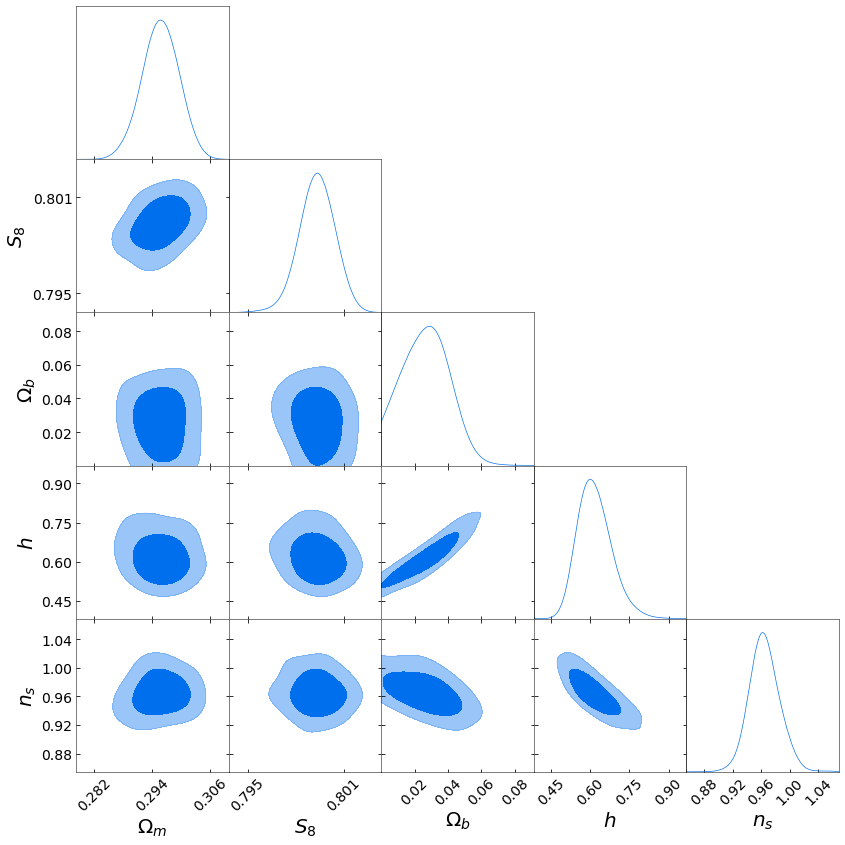

Saving simulators/cosmic_shear/results/mafseq_train_loss.pdf


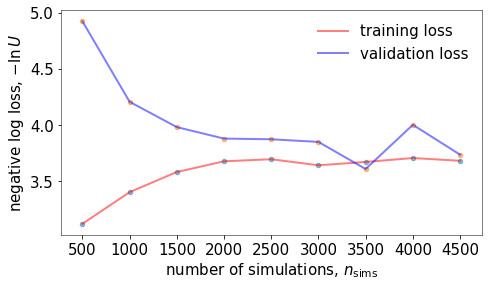

Population 9/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 3.7515, Val_loss: 3.7381
Epoch 00001, Train_loss: 3.7477, Val_loss: 3.7376
Epoch 00002, Train_loss: 3.7385, Val_loss: 3.7441
Epoch 00003, Train_loss: 3.7187, Val_loss: 3.7195
Epoch 00004, Train_loss: 3.7405, Val_loss: 3.7420
Epoch 00005, Train_loss: 3.7250, Val_loss: 3.7381
Epoch 00006, Train_loss: 3.7178, Val_loss: 3.7309
Epoch 00007, Train_loss: 3.7272, Val_loss: 3.7456
Epoch 00008, Train_loss: 3.7205, Val_loss: 3.7351
Epoch 00009, Train_loss: 3.7048, Val_loss: 3.7419
Epoch 00010, Train_loss: 3.7235, Val_loss: 3.7528
Epoch 00011, Train_loss: 3.7367, Val_loss: 3.7842
Epoch 00012, Train_loss: 3.6887, Val_loss: 3.7314
Epoch 00013, Train_loss: 3.6911, Val_loss: 3.7367
Training finished
Best epoch 00012, Val_loss: 3.7195
INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/maftmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/maftmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results/mafseq_train_post_9.pdf


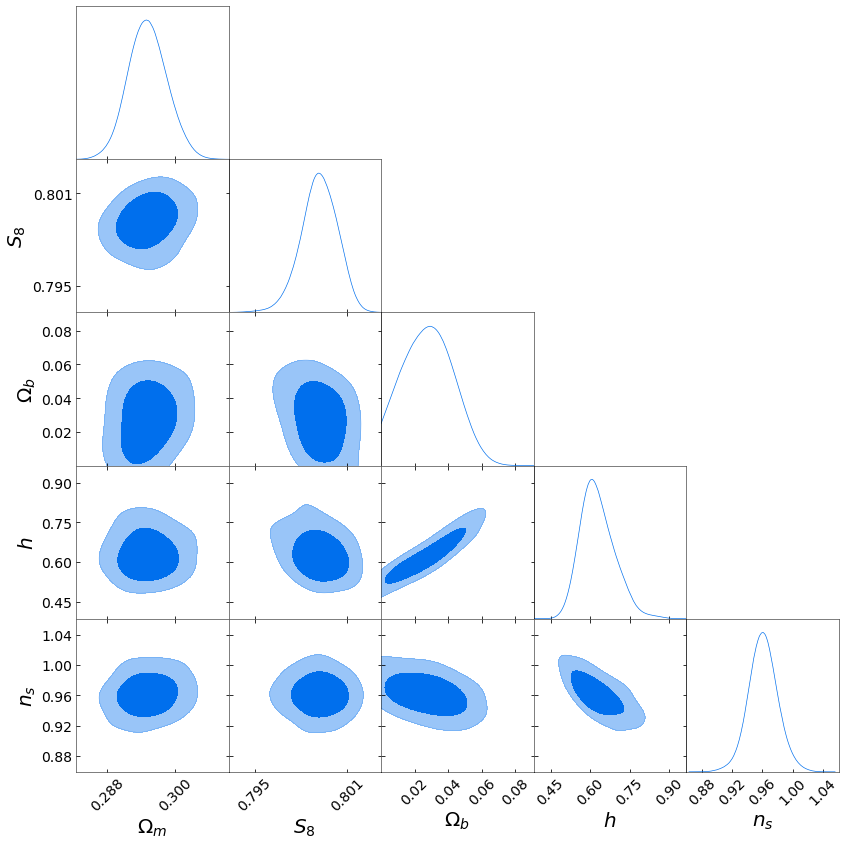

Saving simulators/cosmic_shear/results/mafseq_train_loss.pdf


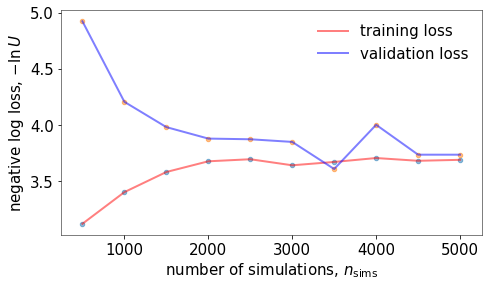

Population 10/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 3.7323, Val_loss: 3.6935
Epoch 00001, Train_loss: 3.7290, Val_loss: 3.6829
Epoch 00002, Train_loss: 3.7130, Val_loss: 3.6860
Epoch 00003, Train_loss: 3.7104, Val_loss: 3.6997
Epoch 00004, Train_loss: 3.7077, Val_loss: 3.6803
Epoch 00005, Train_loss: 3.6964, Val_loss: 3.7037
Epoch 00006, Train_loss: 3.7814, Val_loss: 3.7646
Epoch 00007, Train_loss: 3.6917, Val_loss: 3.7033
Epoch 00008, Train_loss: 3.6877, Val_loss: 3.7035
Epoch 00009, Train_loss: 3.6749, Val_loss: 3.6927
Epoch 00010, Train_loss: 3.6794, Val_loss: 3.7159
Epoch 00011, Train_loss: 3.6901, Val_loss: 3.6839
Epoch 00012, Train_loss: 3.6689, Val_loss: 3.6962
Epoch 00013, Train_loss: 3.6960, Val_loss: 3.7217
Epoch 00014, Train_loss: 3.6595, Val_loss: 3.6888
Training finished
Best epoch 00013, Val_loss: 3.6803
INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/maftmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/maftmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results/mafseq_train_post_10.pdf


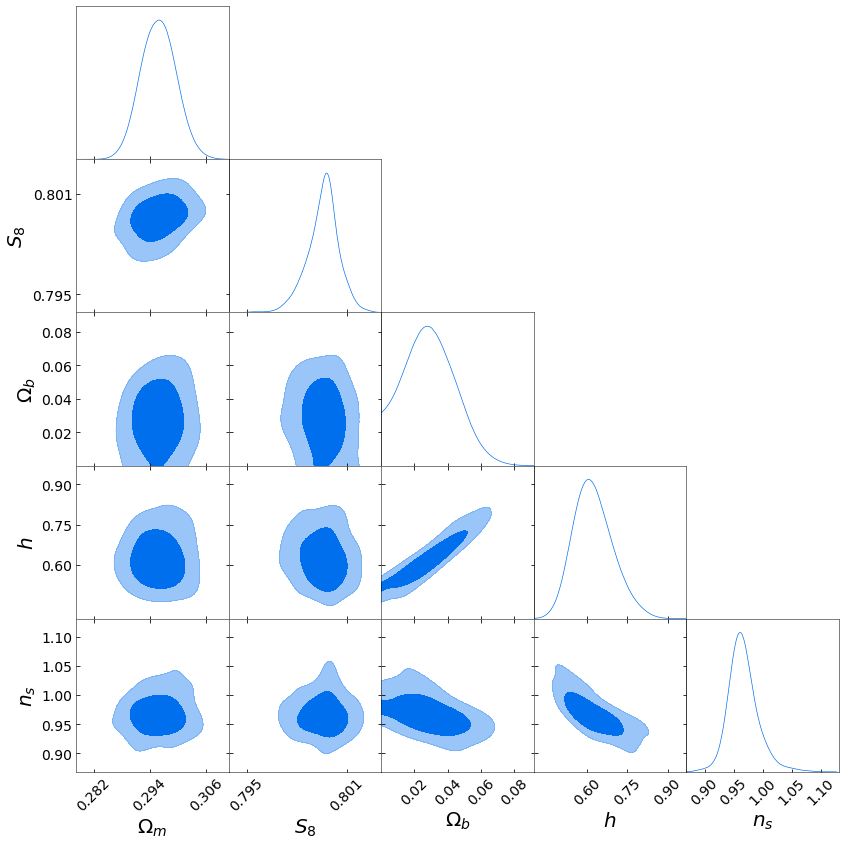

Saving simulators/cosmic_shear/results/mafseq_train_loss.pdf


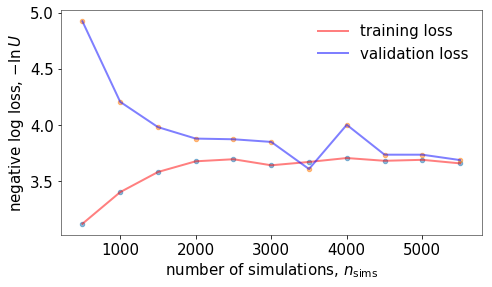

Population 11/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 3.7504, Val_loss: 3.8393
Epoch 00001, Train_loss: 3.7304, Val_loss: 3.8432
Epoch 00002, Train_loss: 3.7349, Val_loss: 3.8452
Epoch 00003, Train_loss: 3.7299, Val_loss: 3.8523
Epoch 00004, Train_loss: 3.7197, Val_loss: 3.8498
Epoch 00005, Train_loss: 3.7190, Val_loss: 3.8601
Epoch 00006, Train_loss: 3.7170, Val_loss: 3.8425
Epoch 00007, Train_loss: 3.6939, Val_loss: 3.8564
Epoch 00008, Train_loss: 3.6929, Val_loss: 3.8528
Epoch 00009, Train_loss: 3.6867, Val_loss: 3.8522
Epoch 00010, Train_loss: 3.6786, Val_loss: 3.8343
Epoch 00011, Train_loss: 3.6742, Val_loss: 3.8507
Epoch 00012, Train_loss: 3.6773, Val_loss: 3.8525
Epoch 00013, Train_loss: 3.6944, Val_loss: 3.8632
Epoch 00014, Train_loss: 3.6748, Val_loss: 3.8462
Epoch 00015, Train_loss: 3.6778, Val_loss: 3.8628
Epoch 00016, Train_loss: 3.6830, Val_loss: 3.8754
Epoch 00017, Train_loss: 3.6748, Val_loss: 3.8758
Epoch 00018, Train_los

INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/maftmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results/mafseq_train_post_11.pdf


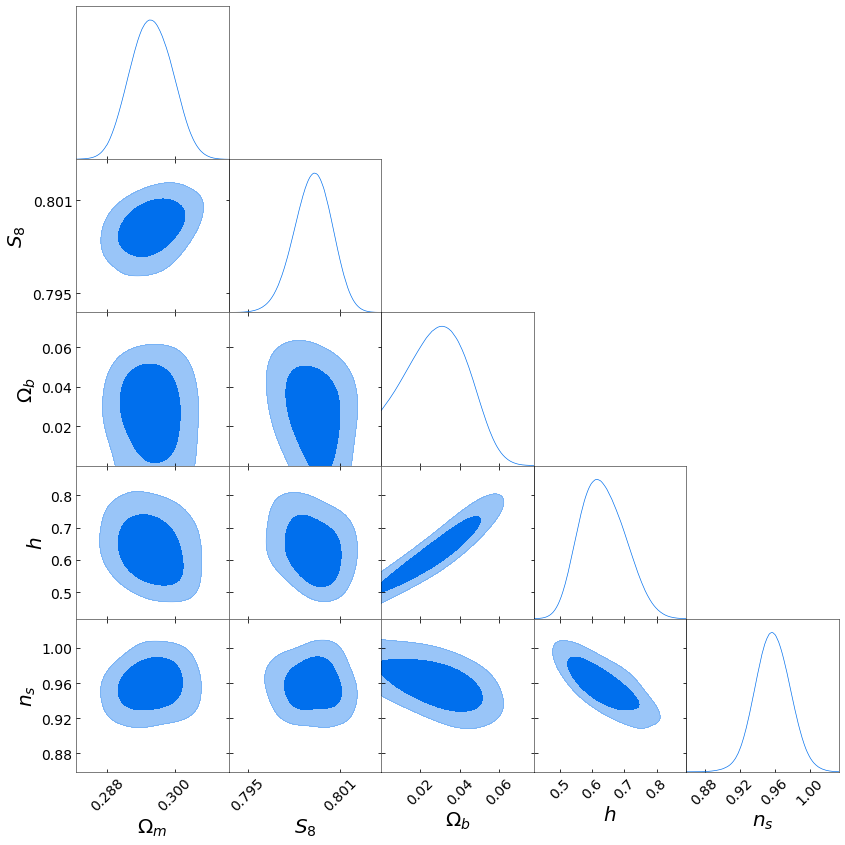

Saving simulators/cosmic_shear/results/mafseq_train_loss.pdf


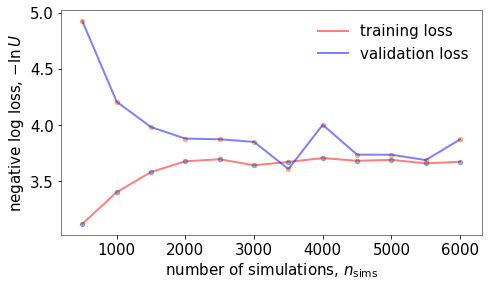

Population 12/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 3.7514, Val_loss: 3.6463
Epoch 00001, Train_loss: 3.7351, Val_loss: 3.6363
Epoch 00002, Train_loss: 3.7478, Val_loss: 3.6515
Epoch 00003, Train_loss: 3.7311, Val_loss: 3.6533
Epoch 00004, Train_loss: 3.7261, Val_loss: 3.6439
Epoch 00005, Train_loss: 3.7197, Val_loss: 3.6522
Epoch 00006, Train_loss: 3.7381, Val_loss: 3.6660
Epoch 00007, Train_loss: 3.7110, Val_loss: 3.6439
Epoch 00008, Train_loss: 3.7276, Val_loss: 3.6715
Epoch 00009, Train_loss: 3.7488, Val_loss: 3.7045
Epoch 00010, Train_loss: 3.7198, Val_loss: 3.6653
Epoch 00011, Train_loss: 3.7054, Val_loss: 3.6694
Training finished
Best epoch 00010, Val_loss: 3.6363
INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/maftmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/maftmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results/mafseq_train_post_12.pdf


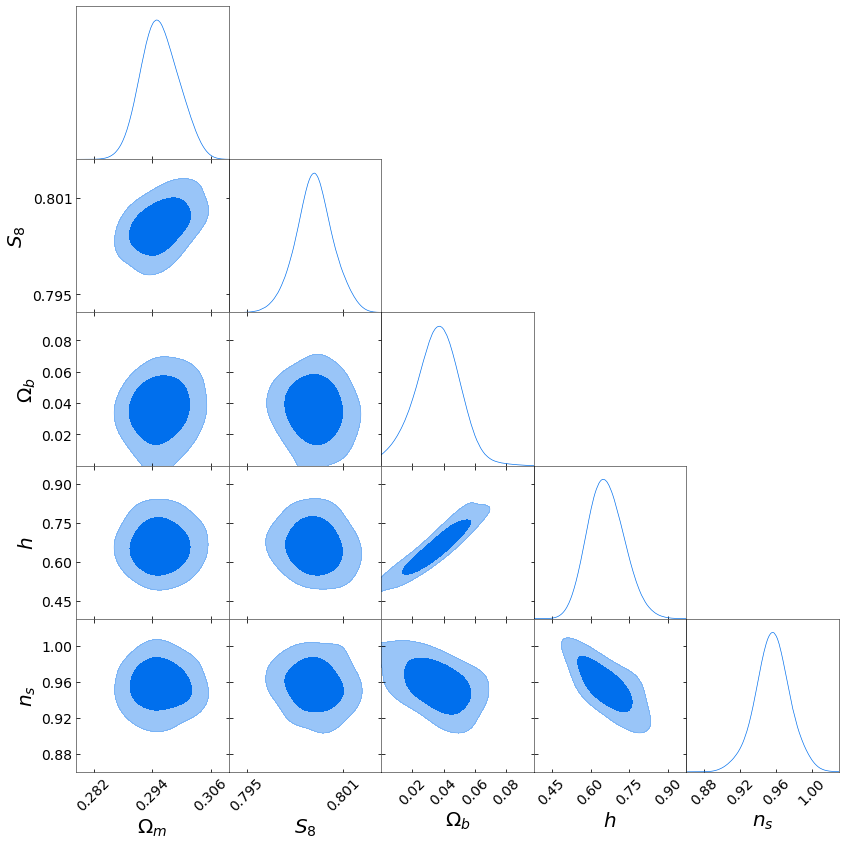

Saving simulators/cosmic_shear/results/mafseq_train_loss.pdf


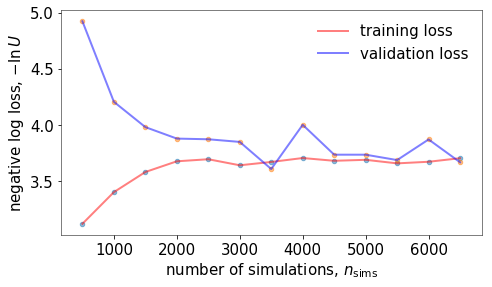

Population 13/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 3.7290, Val_loss: 3.8242
Epoch 00001, Train_loss: 3.7132, Val_loss: 3.8351
Epoch 00002, Train_loss: 3.7265, Val_loss: 3.8522
Epoch 00003, Train_loss: 3.7298, Val_loss: 3.8609
Epoch 00004, Train_loss: 3.7322, Val_loss: 3.8624
Epoch 00005, Train_loss: 3.7620, Val_loss: 3.9022
Epoch 00006, Train_loss: 3.7328, Val_loss: 3.8674
Epoch 00007, Train_loss: 3.7294, Val_loss: 3.8713
Epoch 00008, Train_loss: 3.7147, Val_loss: 3.8557
Epoch 00009, Train_loss: 3.6830, Val_loss: 3.8453
Epoch 00010, Train_loss: 3.6898, Val_loss: 3.8486
Training finished
Best epoch 00009, Val_loss: 3.8242
INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/maftmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/maftmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results/mafseq_train_post_13.pdf


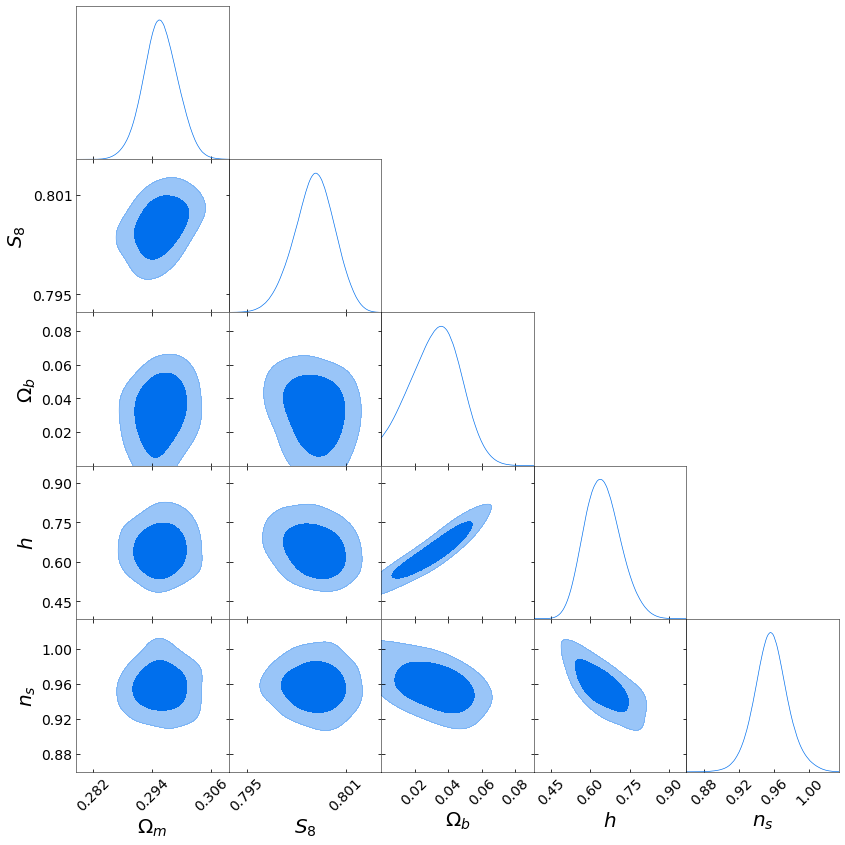

Saving simulators/cosmic_shear/results/mafseq_train_loss.pdf


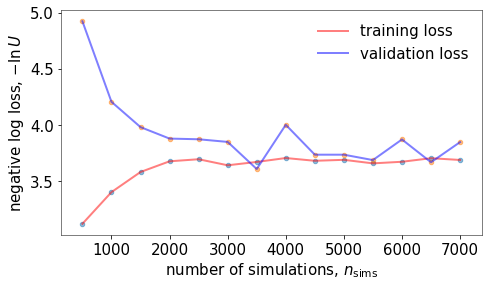

Population 14/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 3.7841, Val_loss: 3.7639
Epoch 00001, Train_loss: 3.7712, Val_loss: 3.7557
Epoch 00002, Train_loss: 3.7715, Val_loss: 3.7701
Epoch 00003, Train_loss: 3.7642, Val_loss: 3.7737
Epoch 00004, Train_loss: 3.7636, Val_loss: 3.7865
Epoch 00005, Train_loss: 3.7519, Val_loss: 3.7724
Epoch 00006, Train_loss: 3.7540, Val_loss: 3.7834
Epoch 00007, Train_loss: 3.7602, Val_loss: 3.7795
Epoch 00008, Train_loss: 3.7443, Val_loss: 3.7862
Epoch 00009, Train_loss: 3.7561, Val_loss: 3.7927
Epoch 00010, Train_loss: 3.7243, Val_loss: 3.7740
Epoch 00011, Train_loss: 3.7299, Val_loss: 3.7879
Training finished
Best epoch 00010, Val_loss: 3.7557
INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/maftmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/maftmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results/mafseq_train_post_14.pdf


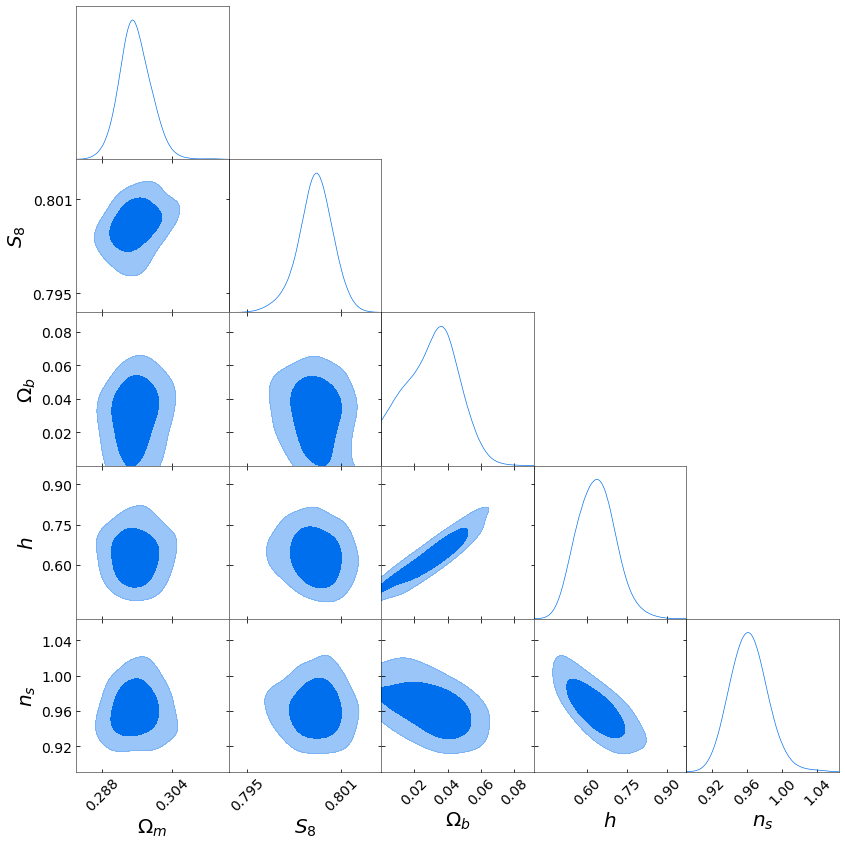

Saving simulators/cosmic_shear/results/mafseq_train_loss.pdf


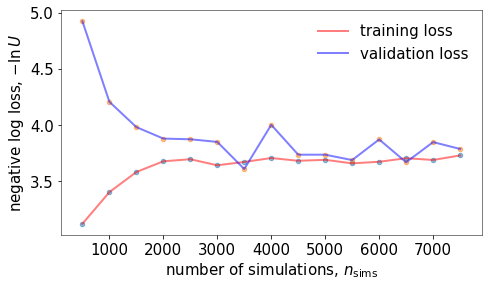

Population 15/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 3.7593, Val_loss: 3.9187
Epoch 00001, Train_loss: 3.7768, Val_loss: 3.9622
Epoch 00002, Train_loss: 3.7564, Val_loss: 3.9278
Epoch 00003, Train_loss: 3.7419, Val_loss: 3.9398
Epoch 00004, Train_loss: 3.7401, Val_loss: 3.9407
Epoch 00005, Train_loss: 3.7636, Val_loss: 3.9517
Epoch 00006, Train_loss: 3.7608, Val_loss: 3.9733
Epoch 00007, Train_loss: 3.7379, Val_loss: 3.9428
Epoch 00008, Train_loss: 3.7349, Val_loss: 3.9560
Epoch 00009, Train_loss: 3.7222, Val_loss: 3.9387
Epoch 00010, Train_loss: 3.7176, Val_loss: 3.9303
Training finished
Best epoch 00009, Val_loss: 3.9187
INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/maftmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/maftmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results/mafseq_train_post_15.pdf


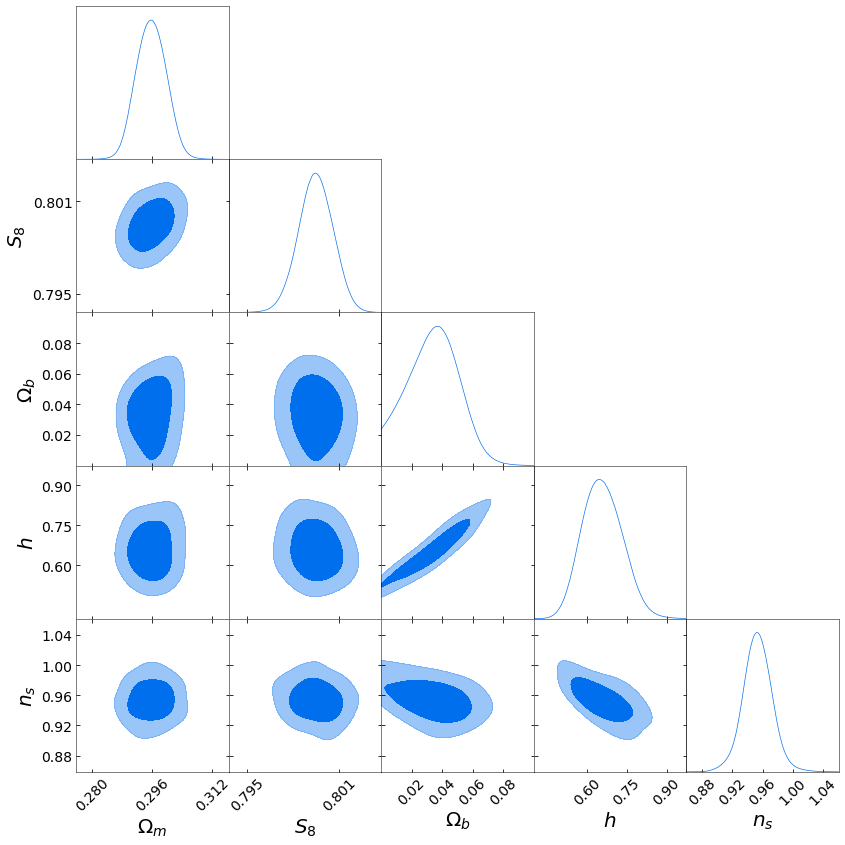

Saving simulators/cosmic_shear/results/mafseq_train_loss.pdf


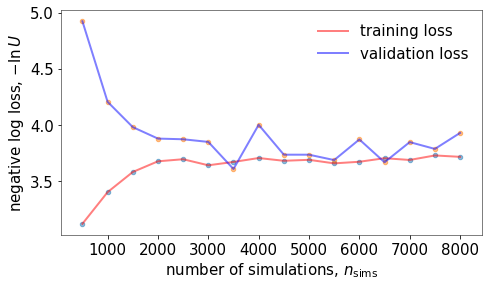

Population 16/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 3.8106, Val_loss: 3.7851
Epoch 00001, Train_loss: 3.7835, Val_loss: 3.7733
Epoch 00002, Train_loss: 3.7806, Val_loss: 3.7759
Epoch 00003, Train_loss: 3.7745, Val_loss: 3.7664
Epoch 00004, Train_loss: 3.7847, Val_loss: 3.7753
Epoch 00005, Train_loss: 3.7717, Val_loss: 3.7732
Epoch 00006, Train_loss: 3.7627, Val_loss: 3.7634
Epoch 00007, Train_loss: 3.7620, Val_loss: 3.7636
Epoch 00008, Train_loss: 3.7527, Val_loss: 3.7677
Epoch 00009, Train_loss: 3.7475, Val_loss: 3.7707
Epoch 00010, Train_loss: 3.7432, Val_loss: 3.7710
Epoch 00011, Train_loss: 3.7398, Val_loss: 3.7723
Epoch 00012, Train_loss: 3.7480, Val_loss: 3.7690
Epoch 00013, Train_loss: 3.7441, Val_loss: 3.7763
Epoch 00014, Train_loss: 3.7432, Val_loss: 3.7759
Epoch 00015, Train_loss: 3.7622, Val_loss: 3.7877
Epoch 00016, Train_loss: 3.7315, Val_loss: 3.7675
Training finished
Best epoch 00015, Val_loss: 3.7634
INFO:tensorflow:Res

INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/maftmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results/mafseq_train_post_16.pdf


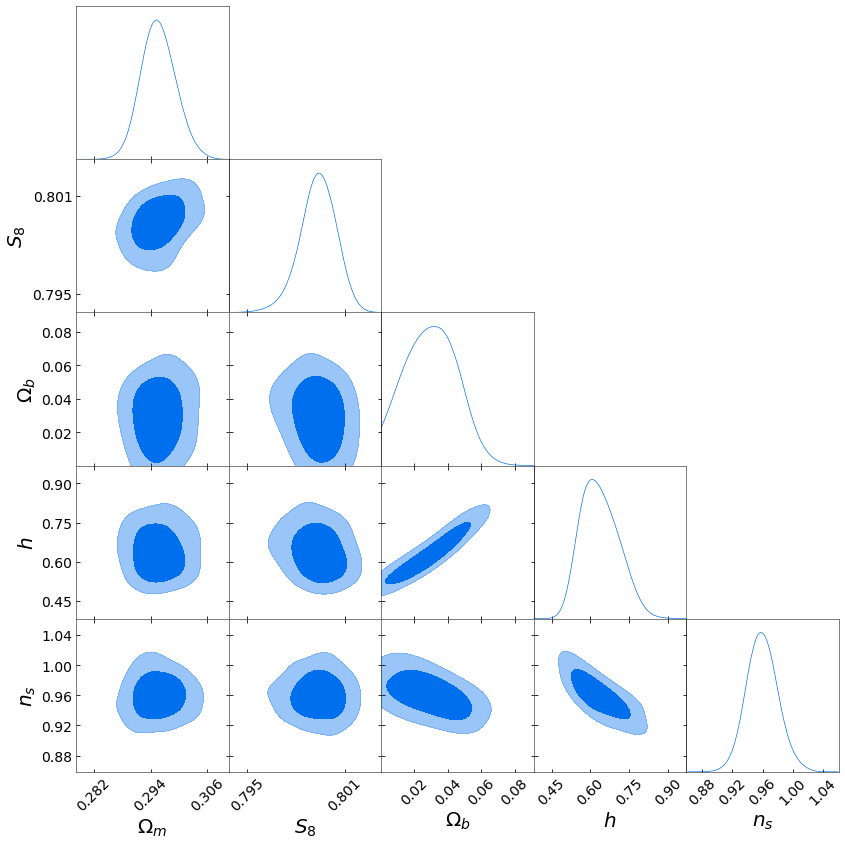

Saving simulators/cosmic_shear/results/mafseq_train_loss.pdf


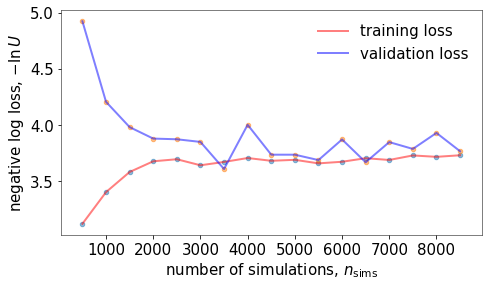

Population 17/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 3.7845, Val_loss: 3.7416
Epoch 00001, Train_loss: 3.7740, Val_loss: 3.7452
Epoch 00002, Train_loss: 3.7633, Val_loss: 3.7424
Epoch 00003, Train_loss: 3.7561, Val_loss: 3.7425
Epoch 00004, Train_loss: 3.7553, Val_loss: 3.7490
Epoch 00005, Train_loss: 3.7510, Val_loss: 3.7475
Epoch 00006, Train_loss: 3.7451, Val_loss: 3.7398
Epoch 00007, Train_loss: 3.7451, Val_loss: 3.7428
Epoch 00008, Train_loss: 3.7460, Val_loss: 3.7484
Epoch 00009, Train_loss: 3.7493, Val_loss: 3.7544
Epoch 00010, Train_loss: 3.7440, Val_loss: 3.7553
Epoch 00011, Train_loss: 3.7268, Val_loss: 3.7419
Epoch 00012, Train_loss: 3.7305, Val_loss: 3.7435
Epoch 00013, Train_loss: 3.7188, Val_loss: 3.7358
Epoch 00014, Train_loss: 3.7414, Val_loss: 3.7622
Epoch 00015, Train_loss: 3.7349, Val_loss: 3.7549
Epoch 00016, Train_loss: 3.7108, Val_loss: 3.7319
Epoch 00017, Train_loss: 3.7172, Val_loss: 3.7465
Epoch 00018, Train_los

INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/maftmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results/mafseq_train_post_17.pdf


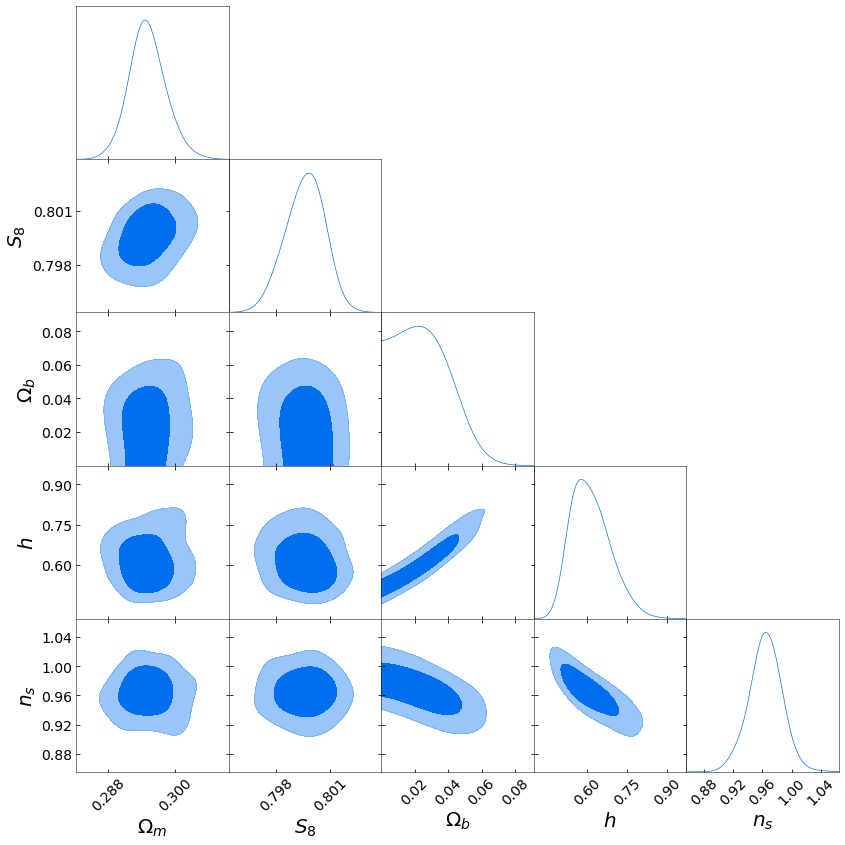

Saving simulators/cosmic_shear/results/mafseq_train_loss.pdf


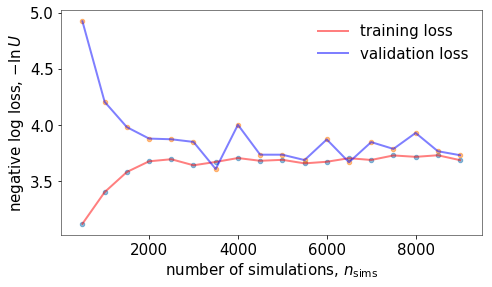

Population 18/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 3.7084, Val_loss: 3.7159
Epoch 00001, Train_loss: 3.7163, Val_loss: 3.7279
Epoch 00002, Train_loss: 3.7041, Val_loss: 3.7266
Epoch 00003, Train_loss: 3.7019, Val_loss: 3.7294
Epoch 00004, Train_loss: 3.7109, Val_loss: 3.7352
Epoch 00005, Train_loss: 3.7092, Val_loss: 3.7484
Epoch 00006, Train_loss: 3.6962, Val_loss: 3.7378
Epoch 00007, Train_loss: 3.6884, Val_loss: 3.7318
Epoch 00008, Train_loss: 3.7088, Val_loss: 3.7524
Epoch 00009, Train_loss: 3.6851, Val_loss: 3.7321
Epoch 00010, Train_loss: 3.6945, Val_loss: 3.7435
Training finished
Best epoch 00009, Val_loss: 3.7159
INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/maftmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/maftmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results/mafseq_train_post_18.pdf


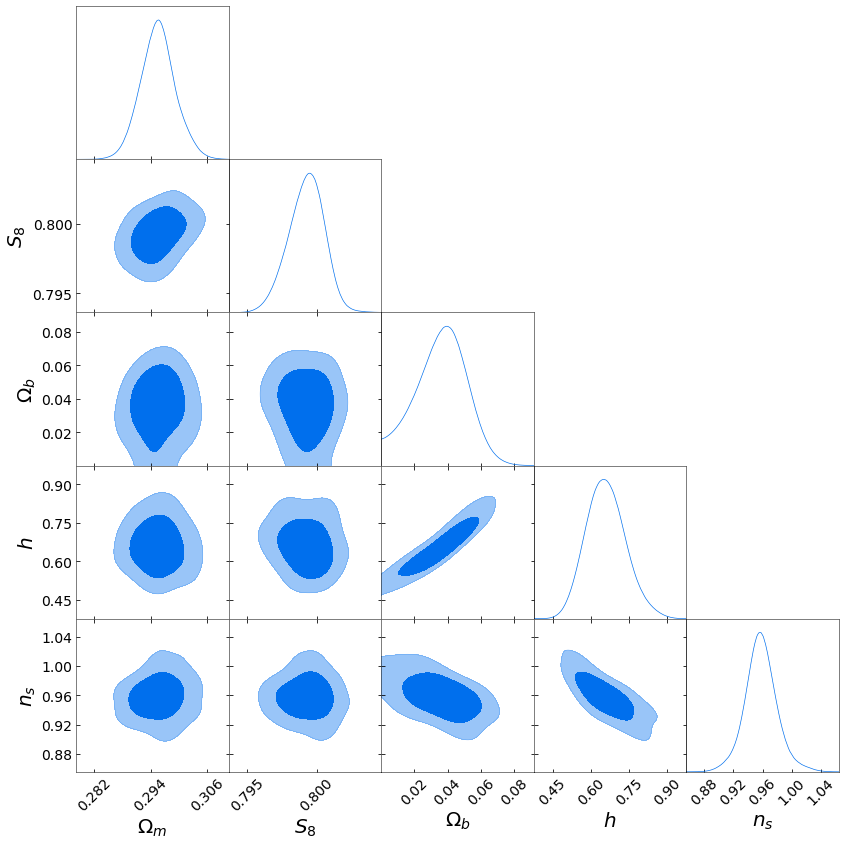

Saving simulators/cosmic_shear/results/mafseq_train_loss.pdf


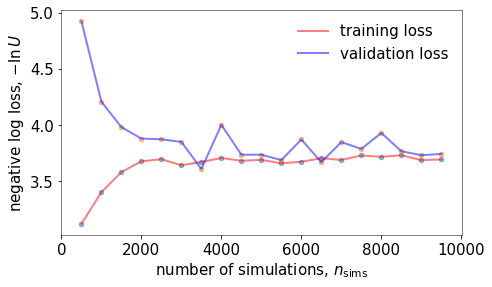

Population 19/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 3.7231, Val_loss: 3.6521
Epoch 00001, Train_loss: 3.7150, Val_loss: 3.6475
Epoch 00002, Train_loss: 3.7204, Val_loss: 3.6600
Epoch 00003, Train_loss: 3.7094, Val_loss: 3.6527
Epoch 00004, Train_loss: 3.7229, Val_loss: 3.6672
Epoch 00005, Train_loss: 3.7147, Val_loss: 3.6667
Epoch 00006, Train_loss: 3.7079, Val_loss: 3.6658
Epoch 00007, Train_loss: 3.7193, Val_loss: 3.6777
Epoch 00008, Train_loss: 3.7135, Val_loss: 3.6846
Epoch 00009, Train_loss: 3.7107, Val_loss: 3.6788
Epoch 00010, Train_loss: 3.7058, Val_loss: 3.6623
Epoch 00011, Train_loss: 3.7020, Val_loss: 3.6675
Training finished
Best epoch 00010, Val_loss: 3.6475
INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/maftmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/maftmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results/mafseq_train_post_19.pdf


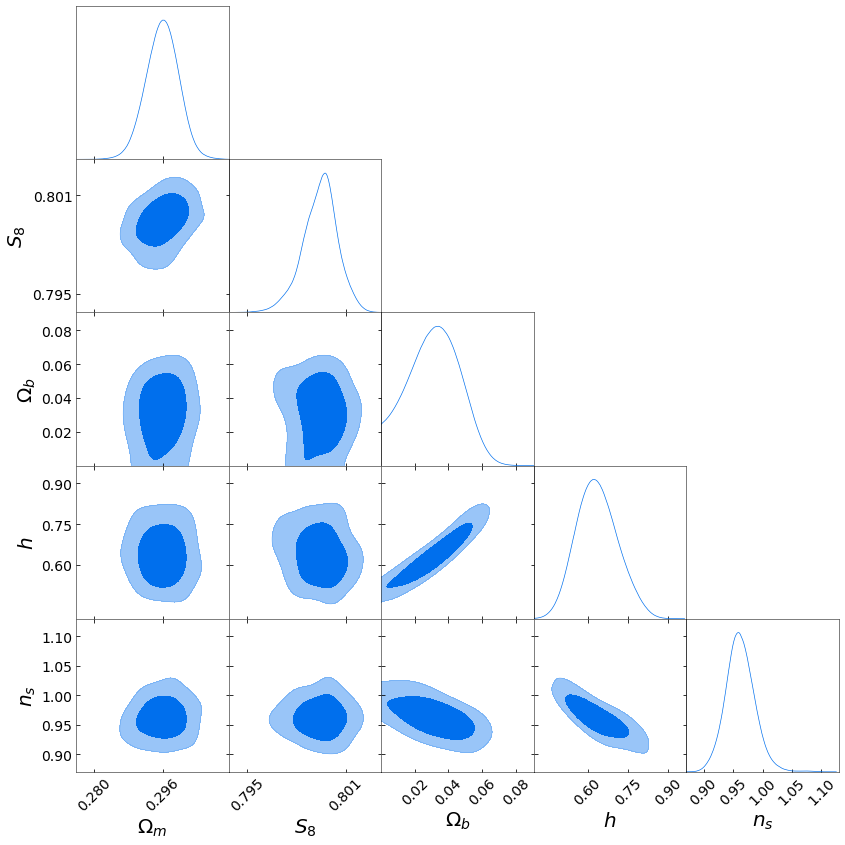

Saving simulators/cosmic_shear/results/mafseq_train_loss.pdf


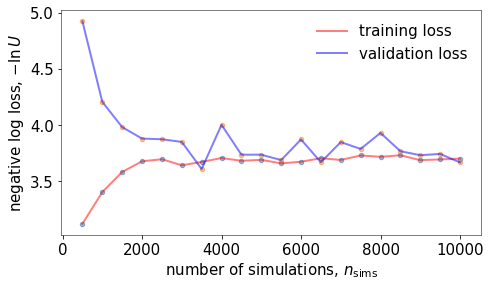

Population 20/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 3.7307, Val_loss: 3.6163
Epoch 00001, Train_loss: 3.7286, Val_loss: 3.6220
Epoch 00002, Train_loss: 3.7269, Val_loss: 3.6257
Epoch 00003, Train_loss: 3.7326, Val_loss: 3.6428
Epoch 00004, Train_loss: 3.7275, Val_loss: 3.6434
Epoch 00005, Train_loss: 3.7139, Val_loss: 3.6346
Epoch 00006, Train_loss: 3.7184, Val_loss: 3.6347
Epoch 00007, Train_loss: 3.7134, Val_loss: 3.6359
Epoch 00008, Train_loss: 3.7080, Val_loss: 3.6408
Epoch 00009, Train_loss: 3.7197, Val_loss: 3.6493
Epoch 00010, Train_loss: 3.7078, Val_loss: 3.6362
Training finished
Best epoch 00009, Val_loss: 3.6163
INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/maftmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/maftmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results/mafseq_train_post_20.pdf


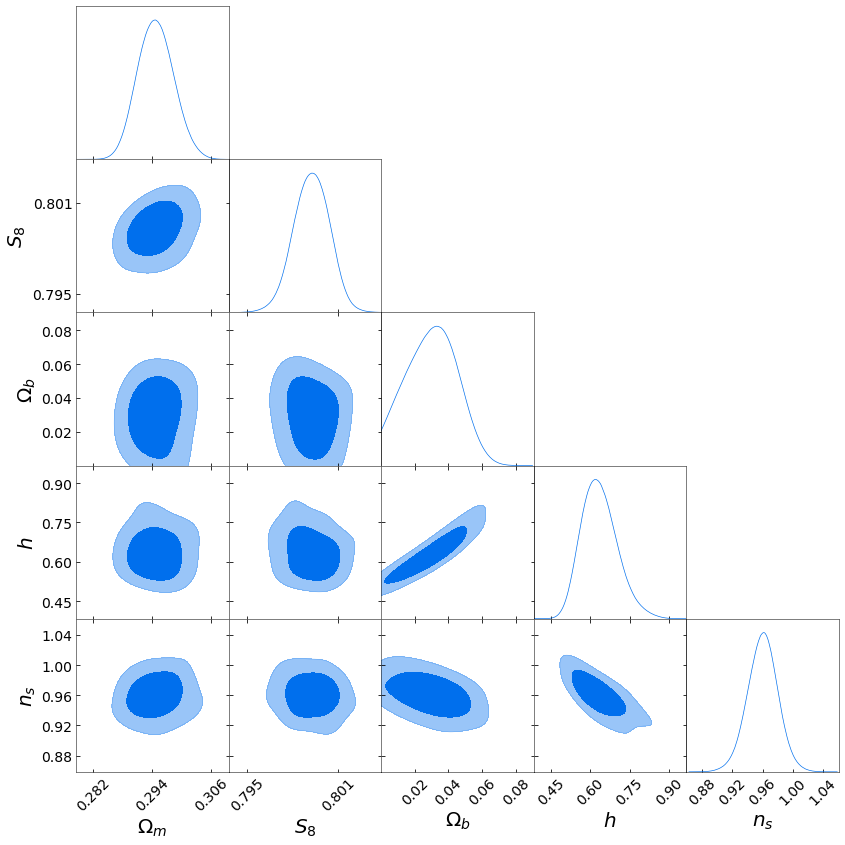

Saving simulators/cosmic_shear/results/mafseq_train_loss.pdf


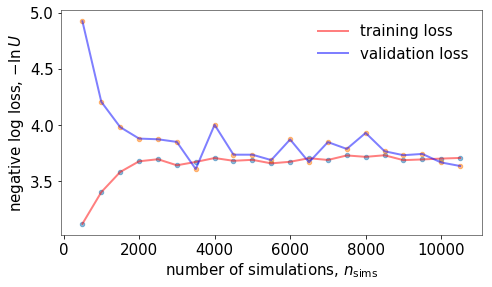

Population 21/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 3.7233, Val_loss: 3.7239
Epoch 00001, Train_loss: 3.7164, Val_loss: 3.7228
Epoch 00002, Train_loss: 3.7324, Val_loss: 3.7514
Epoch 00003, Train_loss: 3.7098, Val_loss: 3.7232
Epoch 00004, Train_loss: 3.7100, Val_loss: 3.7239
Epoch 00005, Train_loss: 3.7108, Val_loss: 3.7387
Epoch 00006, Train_loss: 3.7018, Val_loss: 3.7270
Epoch 00007, Train_loss: 3.7113, Val_loss: 3.7400
Epoch 00008, Train_loss: 3.6945, Val_loss: 3.7260
Epoch 00009, Train_loss: 3.7014, Val_loss: 3.7330
Epoch 00010, Train_loss: 3.6942, Val_loss: 3.7286
Epoch 00011, Train_loss: 3.7113, Val_loss: 3.7531
Training finished
Best epoch 00010, Val_loss: 3.7228
INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/maftmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/maftmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results/mafseq_train_post_21.pdf


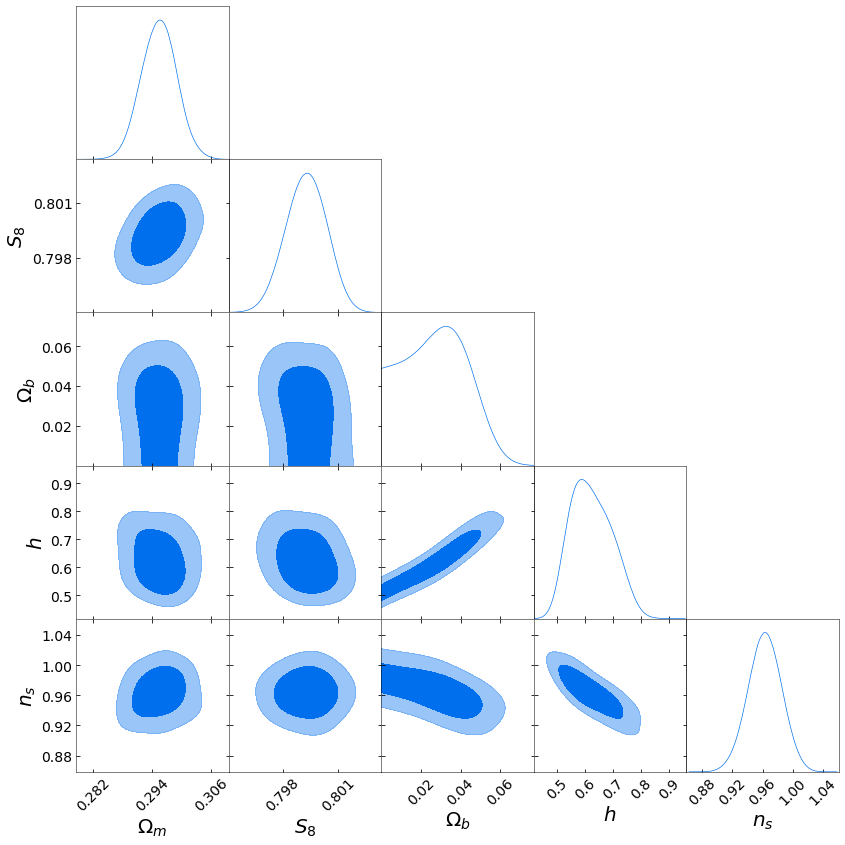

Saving simulators/cosmic_shear/results/mafseq_train_loss.pdf


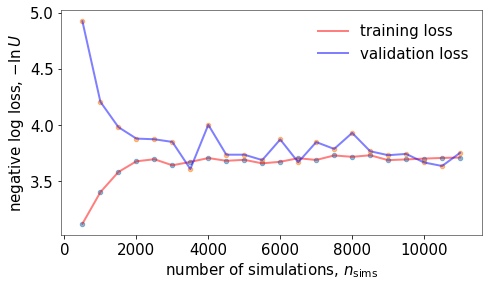

Population 22/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 3.7379, Val_loss: 3.7516
Epoch 00001, Train_loss: 3.7179, Val_loss: 3.7391
Epoch 00002, Train_loss: 3.7205, Val_loss: 3.7480
Epoch 00003, Train_loss: 3.7110, Val_loss: 3.7379
Epoch 00004, Train_loss: 3.7172, Val_loss: 3.7549
Epoch 00005, Train_loss: 3.7087, Val_loss: 3.7454
Epoch 00006, Train_loss: 3.7120, Val_loss: 3.7502
Epoch 00007, Train_loss: 3.7115, Val_loss: 3.7448
Epoch 00008, Train_loss: 3.7014, Val_loss: 3.7399
Epoch 00009, Train_loss: 3.6961, Val_loss: 3.7400
Epoch 00010, Train_loss: 3.6884, Val_loss: 3.7394
Epoch 00011, Train_loss: 3.6962, Val_loss: 3.7526
Epoch 00012, Train_loss: 3.6955, Val_loss: 3.7545
Epoch 00013, Train_loss: 3.6862, Val_loss: 3.7389
Training finished
Best epoch 00012, Val_loss: 3.7379
INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/maftmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/maftmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results/mafseq_train_post_22.pdf


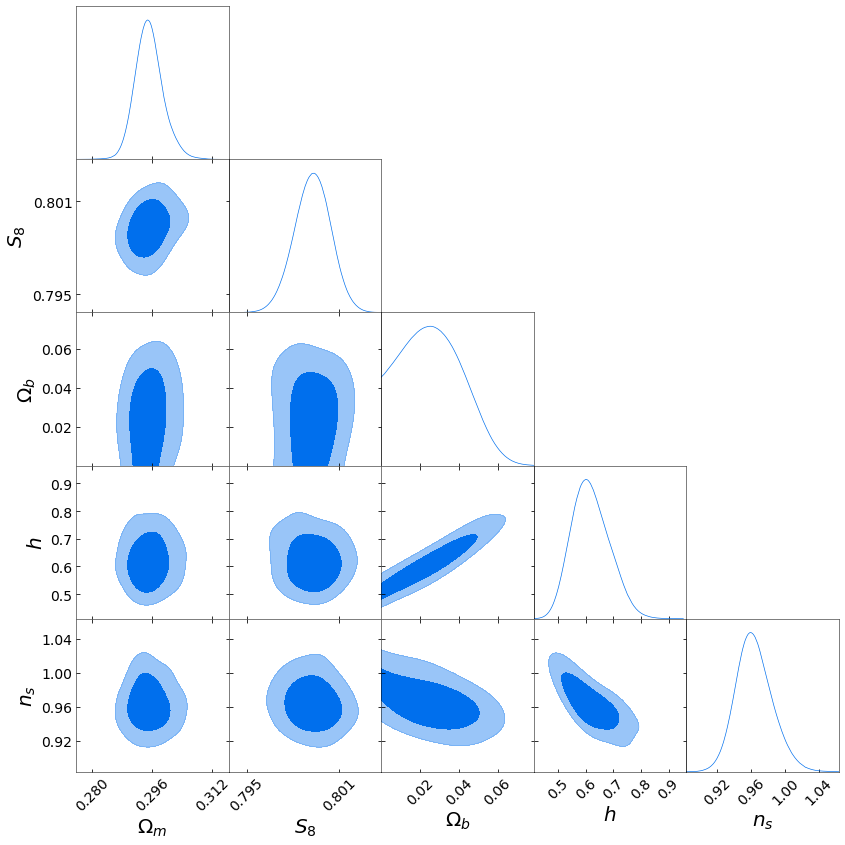

Saving simulators/cosmic_shear/results/mafseq_train_loss.pdf


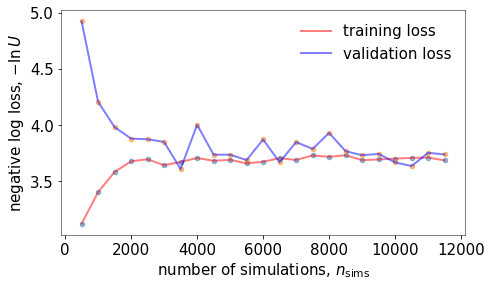

Population 23/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 3.7309, Val_loss: 3.6785
Epoch 00001, Train_loss: 3.7317, Val_loss: 3.6907
Epoch 00002, Train_loss: 3.7378, Val_loss: 3.7208
Epoch 00003, Train_loss: 3.7204, Val_loss: 3.6915
Epoch 00004, Train_loss: 3.7143, Val_loss: 3.6949
Epoch 00005, Train_loss: 3.7138, Val_loss: 3.6828
Epoch 00006, Train_loss: 3.7122, Val_loss: 3.6954
Epoch 00007, Train_loss: 3.7157, Val_loss: 3.7049
Epoch 00008, Train_loss: 3.7149, Val_loss: 3.6915
Epoch 00009, Train_loss: 3.7045, Val_loss: 3.6889
Epoch 00010, Train_loss: 3.7184, Val_loss: 3.7288
Training finished
Best epoch 00009, Val_loss: 3.6785
INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/maftmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/maftmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results/mafseq_train_post_23.pdf


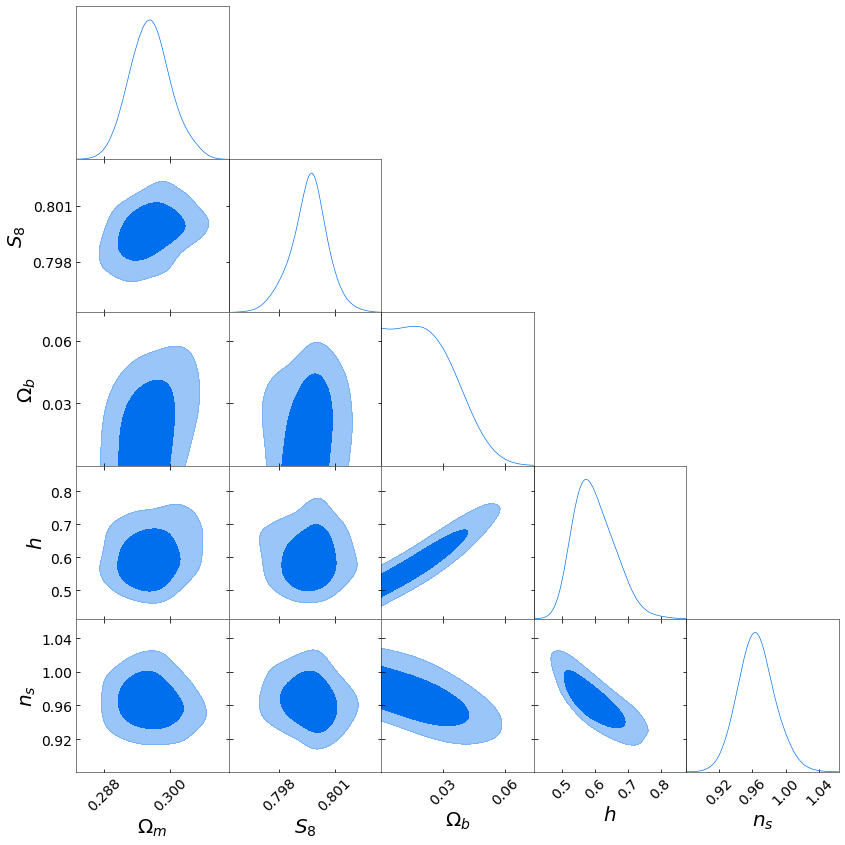

Saving simulators/cosmic_shear/results/mafseq_train_loss.pdf


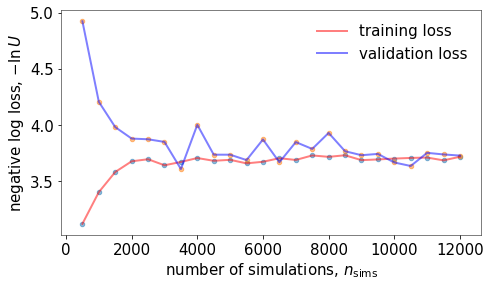

In [8]:
# Initial samples, batch size for population samples, number of populations
n_initial = 500
n_batch = 500
n_populations = 23

# Do the SNL training
DelfiMAF.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=10)

In [9]:
# Create the neural density estimator (MDN)
MDN = ndes.MixtureDensityNetwork(n_inputs=5, n_outputs=5, n_components=3, n_hidden=[50,50], activations=[tf.tanh, tf.tanh])

# Create the DELFI object
DelfiMDN = delfi.Delfi(data, prior, MDN, Finv, theta_fiducial, 
                       param_limits = [lower, upper],
                       param_names = ['\Omega_m', 'S_8', '\Omega_b', 'h', 'n_s'], 
                       results_dir = "simulators/cosmic_shear/results/mdn")

Generating fisher pre-training data...
Training the neural density estimator...
Epoch 00000, Train_loss: 78.0805, Val_loss: 78.2070
Epoch 00001, Train_loss: 40.5724, Val_loss: 41.6736
Epoch 00002, Train_loss: 28.3694, Val_loss: 28.9576
Epoch 00003, Train_loss: 24.0282, Val_loss: 24.5050
Epoch 00004, Train_loss: 21.8788, Val_loss: 22.0033
Epoch 00005, Train_loss: 19.8148, Val_loss: 19.8867
Epoch 00006, Train_loss: 19.4507, Val_loss: 19.4517
Epoch 00007, Train_loss: 18.5267, Val_loss: 18.6138
Epoch 00008, Train_loss: 18.1582, Val_loss: 18.1997
Epoch 00009, Train_loss: 18.1232, Val_loss: 18.1341
Epoch 00010, Train_loss: 17.5835, Val_loss: 17.6218
Epoch 00011, Train_loss: 17.1224, Val_loss: 17.1789
Epoch 00012, Train_loss: 17.2509, Val_loss: 17.2000
Epoch 00013, Train_loss: 17.4479, Val_loss: 17.5228
Epoch 00014, Train_loss: 16.9241, Val_loss: 16.8883
Epoch 00015, Train_loss: 17.3308, Val_loss: 17.3322
Epoch 00016, Train_loss: 16.6352, Val_loss: 16.6525
Epoch 00017, Train_loss: 16.6462, Va

Epoch 00160, Train_loss: 6.7985, Val_loss: 6.8029
Epoch 00161, Train_loss: 6.6147, Val_loss: 6.6112
Epoch 00162, Train_loss: 6.6036, Val_loss: 6.6300
Epoch 00163, Train_loss: 6.5634, Val_loss: 6.6037
Epoch 00164, Train_loss: 6.4531, Val_loss: 6.4491
Epoch 00165, Train_loss: 6.5324, Val_loss: 6.5735
Epoch 00166, Train_loss: 6.8111, Val_loss: 6.8304
Epoch 00167, Train_loss: 6.5922, Val_loss: 6.5619
Epoch 00168, Train_loss: 6.4333, Val_loss: 6.4471
Epoch 00169, Train_loss: 6.2949, Val_loss: 6.2998
Epoch 00170, Train_loss: 6.5033, Val_loss: 6.5035
Epoch 00171, Train_loss: 6.5088, Val_loss: 6.4949
Epoch 00172, Train_loss: 6.5169, Val_loss: 6.5499
Epoch 00173, Train_loss: 6.6795, Val_loss: 6.6682
Epoch 00174, Train_loss: 6.8792, Val_loss: 6.8536
Epoch 00175, Train_loss: 6.4495, Val_loss: 6.4868
Epoch 00176, Train_loss: 6.3708, Val_loss: 6.3538
Epoch 00177, Train_loss: 6.6236, Val_loss: 6.6138
Epoch 00178, Train_loss: 6.7000, Val_loss: 6.7270
Epoch 00179, Train_loss: 6.4673, Val_loss: 6.5040


Epoch 00324, Train_loss: 4.8678, Val_loss: 4.8621
Epoch 00325, Train_loss: 4.9480, Val_loss: 4.9231
Epoch 00326, Train_loss: 7.1974, Val_loss: 7.1834
Epoch 00327, Train_loss: 4.8585, Val_loss: 4.8474
Epoch 00328, Train_loss: 5.0034, Val_loss: 4.9771
Epoch 00329, Train_loss: 4.9436, Val_loss: 4.9154
Epoch 00330, Train_loss: 4.9660, Val_loss: 4.9491
Epoch 00331, Train_loss: 5.1205, Val_loss: 5.1222
Epoch 00332, Train_loss: 4.9556, Val_loss: 4.9272
Epoch 00333, Train_loss: 4.9147, Val_loss: 4.9028
Epoch 00334, Train_loss: 5.1040, Val_loss: 5.0839
Epoch 00335, Train_loss: 5.2489, Val_loss: 5.2337
Epoch 00336, Train_loss: 4.8376, Val_loss: 4.8250
Epoch 00337, Train_loss: 4.9219, Val_loss: 4.9124
Epoch 00338, Train_loss: 5.1407, Val_loss: 5.1153
Epoch 00339, Train_loss: 4.8389, Val_loss: 4.8301
Epoch 00340, Train_loss: 5.1321, Val_loss: 5.1103
Epoch 00341, Train_loss: 4.8126, Val_loss: 4.8069
Epoch 00342, Train_loss: 4.8121, Val_loss: 4.8002
Epoch 00343, Train_loss: 4.8999, Val_loss: 4.8909


Epoch 00488, Train_loss: 4.5815, Val_loss: 4.5777
Epoch 00489, Train_loss: 4.4135, Val_loss: 4.4022
Epoch 00490, Train_loss: 4.7616, Val_loss: 4.7492
Epoch 00491, Train_loss: 4.5673, Val_loss: 4.5655
Epoch 00492, Train_loss: 4.6405, Val_loss: 4.6121
Epoch 00493, Train_loss: 4.5768, Val_loss: 4.5664
Epoch 00494, Train_loss: 4.4109, Val_loss: 4.4172
Epoch 00495, Train_loss: 4.5758, Val_loss: 4.5796
Epoch 00496, Train_loss: 4.5483, Val_loss: 4.5295
Epoch 00497, Train_loss: 5.3326, Val_loss: 5.3127
Epoch 00498, Train_loss: 4.6694, Val_loss: 4.6561
Epoch 00499, Train_loss: 4.9629, Val_loss: 4.9835
Training finished
Best epoch 00498, Val_loss: 4.4022
INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/mdntmp_model


Done.
Sampling approximate posterior...
Done.
Plotting the posterior (1D and 2D marginals)...
Saving simulators/cosmic_shear/results/mdnfisher_pretrain_post.pdf


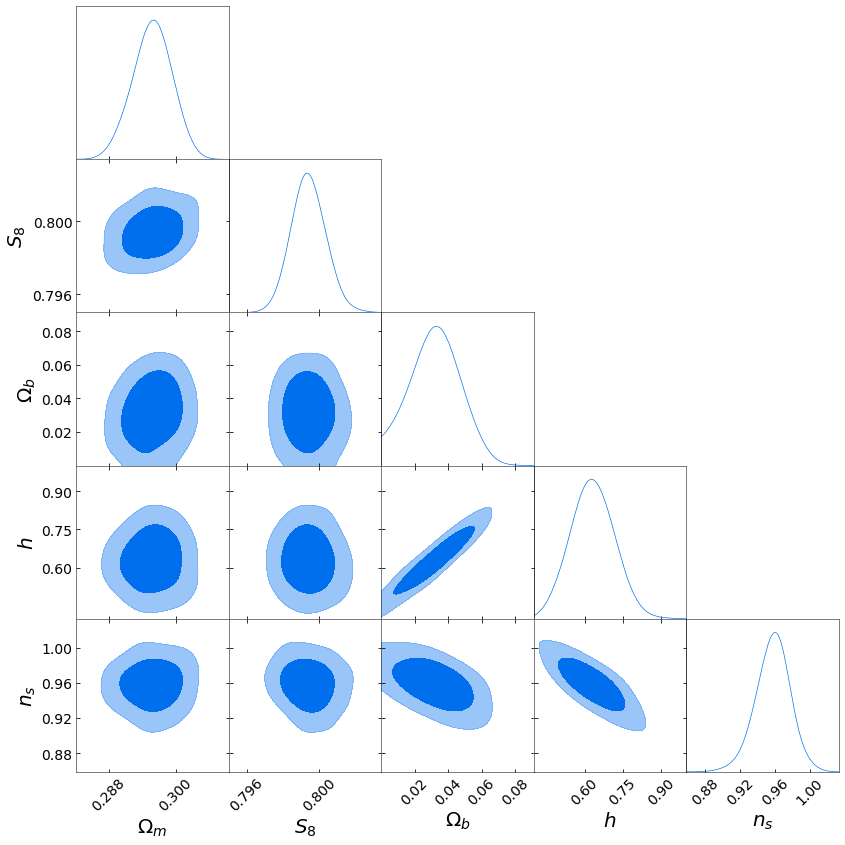

In [10]:
# Do the Fisher pre-training
DelfiMDN.fisher_pretraining(50000, prior, epochs=500, patience=100)

Running initial 500 sims...
Done.
Epoch 00000, Train_loss: 17.0224, Val_loss: 15.0110
Epoch 00001, Train_loss: 13.6332, Val_loss: 12.8906
Epoch 00002, Train_loss: 12.2647, Val_loss: 9.5893
Epoch 00003, Train_loss: 8.5156, Val_loss: 7.8504
Epoch 00004, Train_loss: 7.6465, Val_loss: 9.0024
Epoch 00005, Train_loss: 6.4878, Val_loss: 6.9037
Epoch 00006, Train_loss: 5.9436, Val_loss: 6.5390
Epoch 00007, Train_loss: 5.6600, Val_loss: 6.3190
Epoch 00008, Train_loss: 5.7201, Val_loss: 5.8837
Epoch 00009, Train_loss: 5.4722, Val_loss: 5.7783
Epoch 00010, Train_loss: 5.2854, Val_loss: 5.8124
Epoch 00011, Train_loss: 5.4433, Val_loss: 6.2881
Epoch 00012, Train_loss: 5.2288, Val_loss: 5.5753
Epoch 00013, Train_loss: 5.1198, Val_loss: 5.5599
Epoch 00014, Train_loss: 5.1889, Val_loss: 5.8468
Epoch 00015, Train_loss: 5.0401, Val_loss: 5.5077
Epoch 00016, Train_loss: 4.9802, Val_loss: 5.5234
Epoch 00017, Train_loss: 5.0217, Val_loss: 5.3231
Epoch 00018, Train_loss: 4.9316, Val_loss: 5.4966
Epoch 00019

INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/mdntmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results/mdnseq_train_post_0.pdf


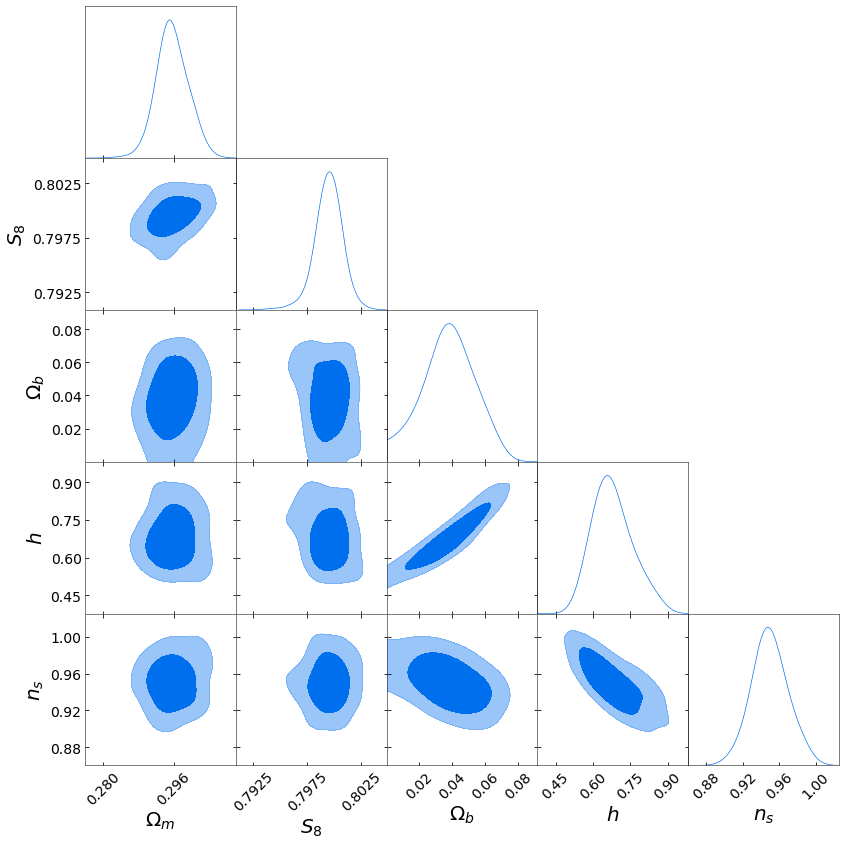

Population 1/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 4.0584, Val_loss: 3.9461
Epoch 00001, Train_loss: 4.0334, Val_loss: 3.9440
Epoch 00002, Train_loss: 3.9976, Val_loss: 3.9073
Epoch 00003, Train_loss: 3.9927, Val_loss: 3.8933
Epoch 00004, Train_loss: 3.9790, Val_loss: 3.8919
Epoch 00005, Train_loss: 3.9614, Val_loss: 3.8734
Epoch 00006, Train_loss: 3.9655, Val_loss: 3.8759
Epoch 00007, Train_loss: 3.9594, Val_loss: 3.8894
Epoch 00008, Train_loss: 3.9480, Val_loss: 3.8803
Epoch 00009, Train_loss: 3.9548, Val_loss: 3.8787
Epoch 00010, Train_loss: 3.9518, Val_loss: 3.8727
Epoch 00011, Train_loss: 3.9279, Val_loss: 3.8647
Epoch 00012, Train_loss: 3.9289, Val_loss: 3.8563
Epoch 00013, Train_loss: 3.9177, Val_loss: 3.8612
Epoch 00014, Train_loss: 3.9090, Val_loss: 3.8597
Epoch 00015, Train_loss: 3.9076, Val_loss: 3.8533
Epoch 00016, Train_loss: 3.9220, Val_loss: 3.8783
Epoch 00017, Train_loss: 3.8954, Val_loss: 3.8503
Epoch 00018, Train_loss

INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/mdntmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results/mdnseq_train_post_1.pdf


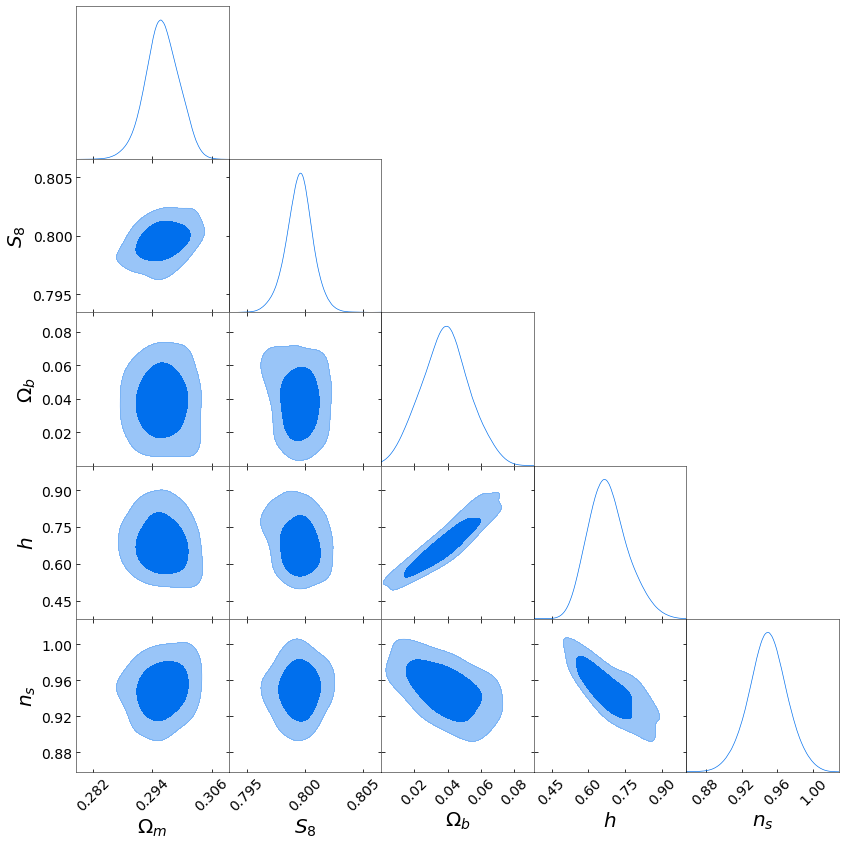

Saving simulators/cosmic_shear/results/mdnseq_train_loss.pdf


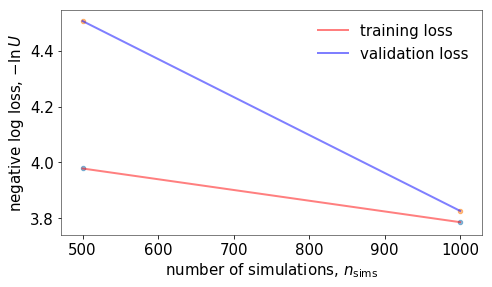

Population 2/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 4.0151, Val_loss: 3.8350
Epoch 00001, Train_loss: 3.9862, Val_loss: 3.8623
Epoch 00002, Train_loss: 3.9849, Val_loss: 3.8572
Epoch 00003, Train_loss: 3.9580, Val_loss: 3.8463
Epoch 00004, Train_loss: 3.9746, Val_loss: 3.9174
Epoch 00005, Train_loss: 3.9499, Val_loss: 3.8804
Epoch 00006, Train_loss: 3.9373, Val_loss: 3.8429
Epoch 00007, Train_loss: 3.9393, Val_loss: 3.8635
Epoch 00008, Train_loss: 3.9257, Val_loss: 3.8597
Epoch 00009, Train_loss: 3.9210, Val_loss: 3.8469
Epoch 00010, Train_loss: 3.9265, Val_loss: 3.8475
Training finished
Best epoch 00009, Val_loss: 3.8350
INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/mdntmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results/mdnseq_train_post_2.pdf


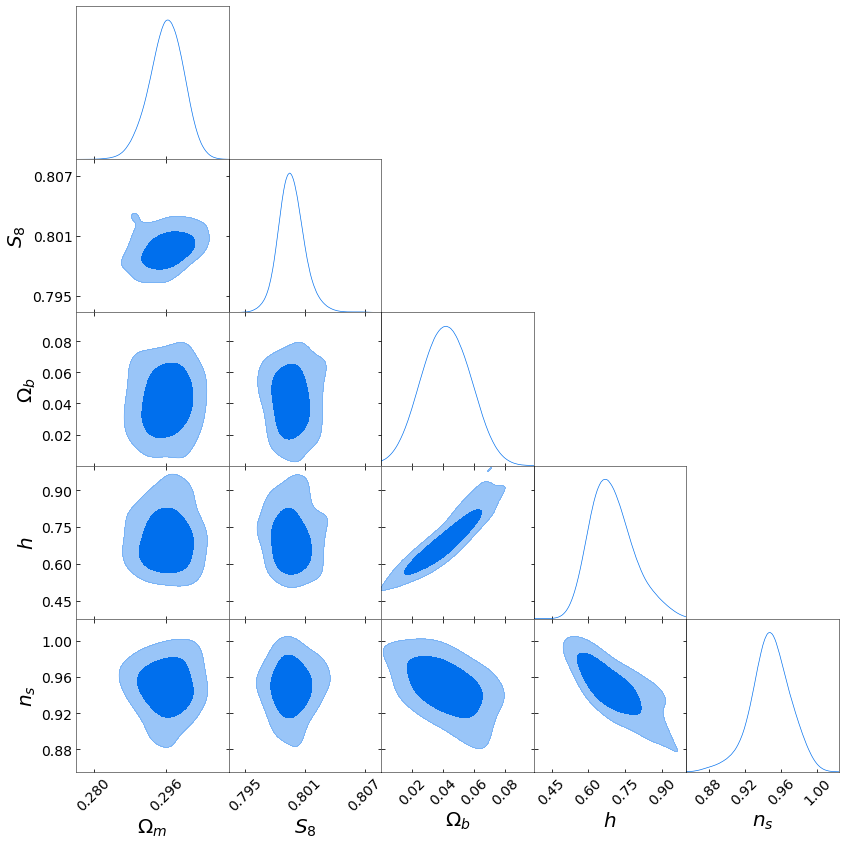

Saving simulators/cosmic_shear/results/mdnseq_train_loss.pdf


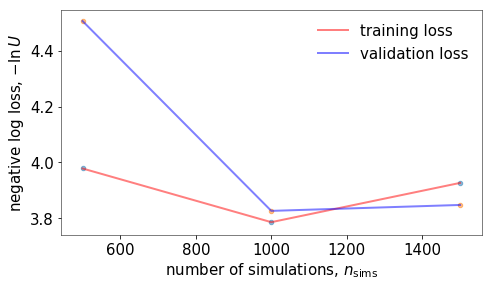

Population 3/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 3.9383, Val_loss: 4.2699
Epoch 00001, Train_loss: 3.9185, Val_loss: 4.2557
Epoch 00002, Train_loss: 3.9163, Val_loss: 4.2578
Epoch 00003, Train_loss: 3.8968, Val_loss: 4.2542
Epoch 00004, Train_loss: 3.8907, Val_loss: 4.2294
Epoch 00005, Train_loss: 3.8912, Val_loss: 4.2432
Epoch 00006, Train_loss: 3.8912, Val_loss: 4.2349
Epoch 00007, Train_loss: 3.8781, Val_loss: 4.2457
Epoch 00008, Train_loss: 3.8654, Val_loss: 4.2229
Epoch 00009, Train_loss: 3.8813, Val_loss: 4.2422
Epoch 00010, Train_loss: 3.8696, Val_loss: 4.2418
Epoch 00011, Train_loss: 3.8549, Val_loss: 4.2245
Epoch 00012, Train_loss: 3.8535, Val_loss: 4.2174
Epoch 00013, Train_loss: 3.8517, Val_loss: 4.1975
Epoch 00014, Train_loss: 3.8552, Val_loss: 4.2334
Epoch 00015, Train_loss: 3.8452, Val_loss: 4.2080
Epoch 00016, Train_loss: 3.8522, Val_loss: 4.2228
Epoch 00017, Train_loss: 3.8379, Val_loss: 4.1967
Epoch 00018, Train_loss

INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/mdntmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results/mdnseq_train_post_3.pdf


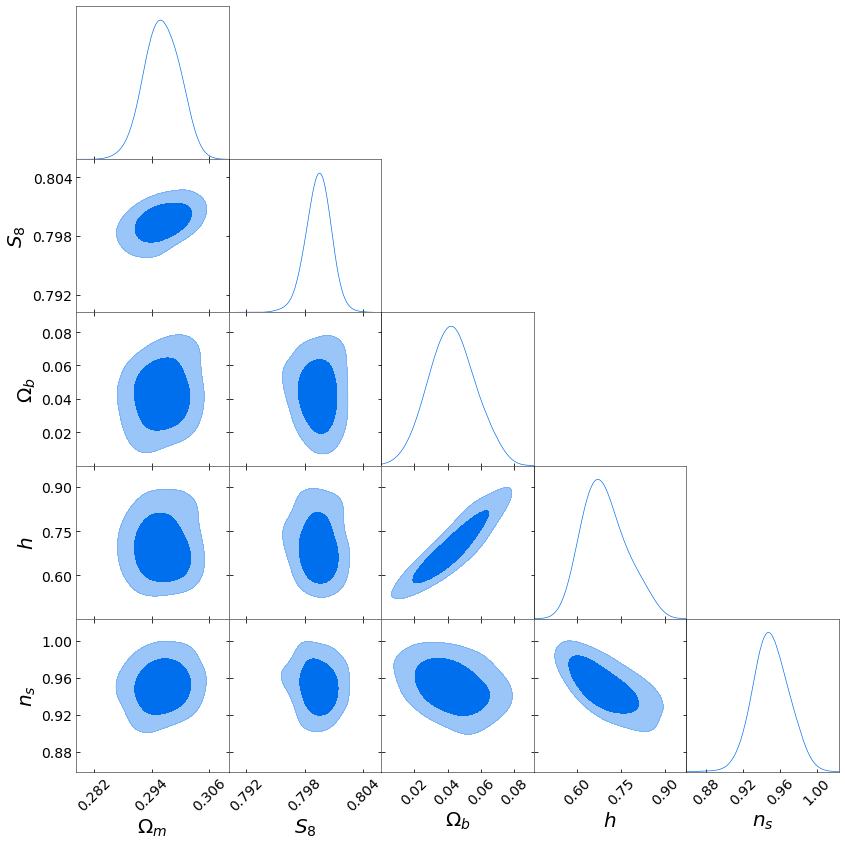

Saving simulators/cosmic_shear/results/mdnseq_train_loss.pdf


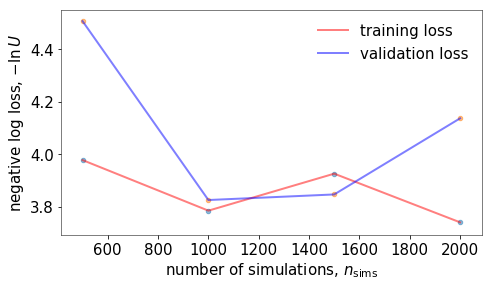

Population 4/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 3.7930, Val_loss: 3.8190
Epoch 00001, Train_loss: 3.7870, Val_loss: 3.8365
Epoch 00002, Train_loss: 3.7838, Val_loss: 3.8329
Epoch 00003, Train_loss: 3.7770, Val_loss: 3.8334
Epoch 00004, Train_loss: 3.7885, Val_loss: 3.8212
Epoch 00005, Train_loss: 3.7653, Val_loss: 3.8269
Epoch 00006, Train_loss: 3.7619, Val_loss: 3.8100
Epoch 00007, Train_loss: 3.7761, Val_loss: 3.8295
Epoch 00008, Train_loss: 3.7834, Val_loss: 3.8599
Epoch 00009, Train_loss: 3.7653, Val_loss: 3.8200
Epoch 00010, Train_loss: 3.7580, Val_loss: 3.8042
Epoch 00011, Train_loss: 3.7524, Val_loss: 3.8317
Epoch 00012, Train_loss: 3.7524, Val_loss: 3.8161
Epoch 00013, Train_loss: 3.7511, Val_loss: 3.8219
Epoch 00014, Train_loss: 3.7571, Val_loss: 3.8516
Epoch 00015, Train_loss: 3.7596, Val_loss: 3.8394
Epoch 00016, Train_loss: 3.7462, Val_loss: 3.8334
Epoch 00017, Train_loss: 3.7483, Val_loss: 3.8261
Epoch 00018, Train_loss

INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/mdntmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results/mdnseq_train_post_4.pdf


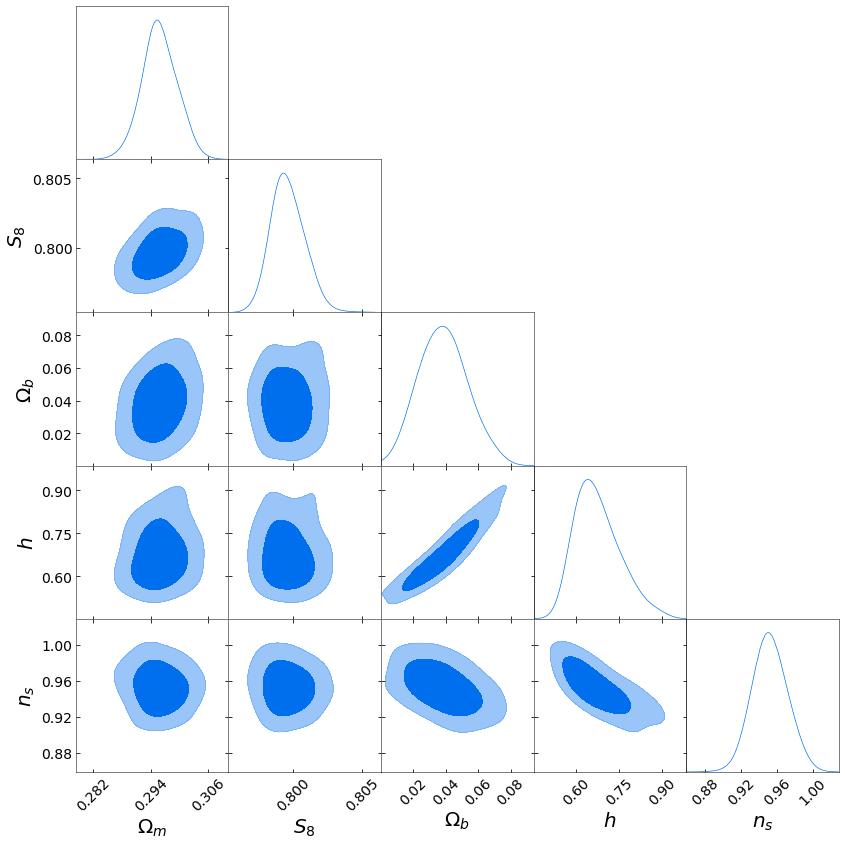

Saving simulators/cosmic_shear/results/mdnseq_train_loss.pdf


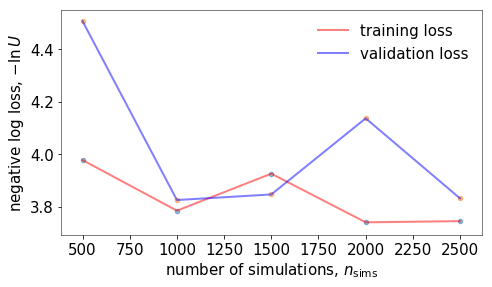

Population 5/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 4.0239, Val_loss: 4.1934
Epoch 00001, Train_loss: 4.0027, Val_loss: 4.2010
Epoch 00002, Train_loss: 3.9645, Val_loss: 4.1152
Epoch 00003, Train_loss: 3.9403, Val_loss: 4.1186
Epoch 00004, Train_loss: 3.9314, Val_loss: 4.1049
Epoch 00005, Train_loss: 3.9252, Val_loss: 4.0960
Epoch 00006, Train_loss: 3.9247, Val_loss: 4.1118
Epoch 00007, Train_loss: 3.9195, Val_loss: 4.1078
Epoch 00008, Train_loss: 3.9179, Val_loss: 4.1035
Epoch 00009, Train_loss: 3.9148, Val_loss: 4.1051
Epoch 00010, Train_loss: 3.9099, Val_loss: 4.1018
Epoch 00011, Train_loss: 3.9047, Val_loss: 4.0998
Epoch 00012, Train_loss: 3.8992, Val_loss: 4.0906
Epoch 00013, Train_loss: 3.9122, Val_loss: 4.0996
Epoch 00014, Train_loss: 3.9321, Val_loss: 4.1480
Epoch 00015, Train_loss: 3.9057, Val_loss: 4.1154
Epoch 00016, Train_loss: 3.9097, Val_loss: 4.1121
Epoch 00017, Train_loss: 3.9051, Val_loss: 4.1205
Epoch 00018, Train_loss

INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/mdntmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results/mdnseq_train_post_5.pdf


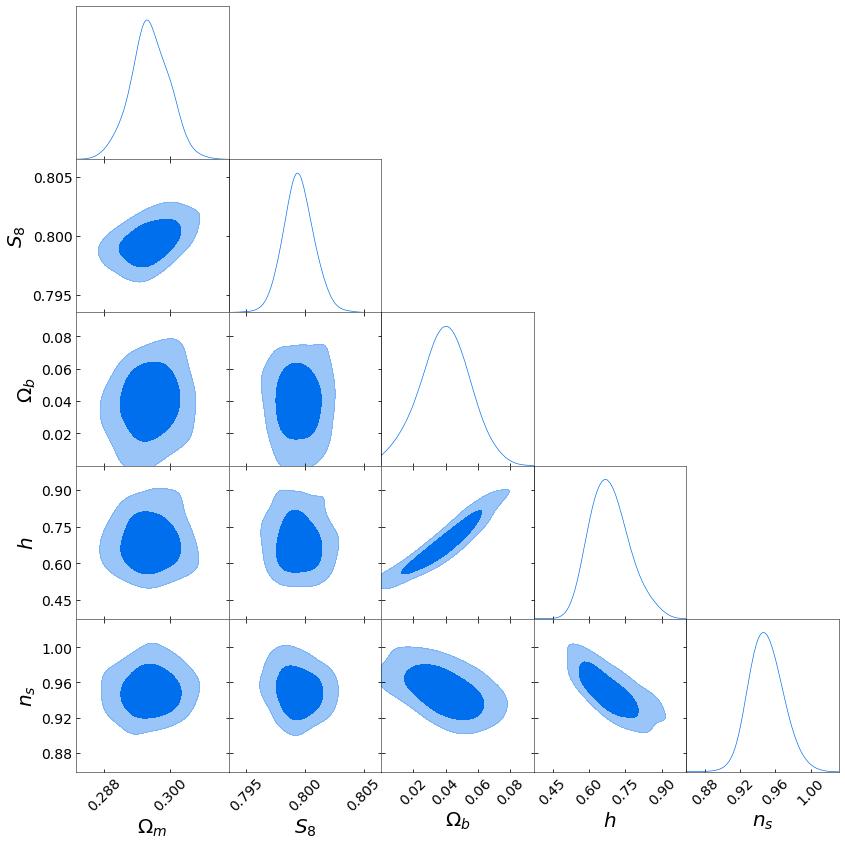

Saving simulators/cosmic_shear/results/mdnseq_train_loss.pdf


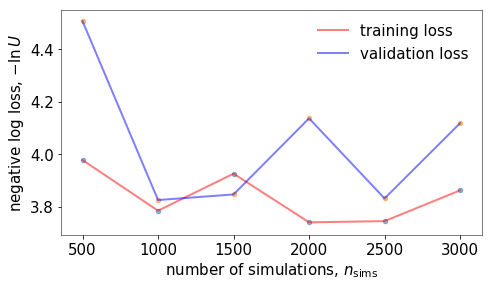

Population 6/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 3.8816, Val_loss: 3.7367
Epoch 00001, Train_loss: 3.8884, Val_loss: 3.7542
Epoch 00002, Train_loss: 3.8958, Val_loss: 3.7720
Epoch 00003, Train_loss: 3.8972, Val_loss: 3.7700
Epoch 00004, Train_loss: 3.8791, Val_loss: 3.7649
Epoch 00005, Train_loss: 3.8665, Val_loss: 3.7624
Epoch 00006, Train_loss: 3.8671, Val_loss: 3.7514
Epoch 00007, Train_loss: 3.8671, Val_loss: 3.7576
Epoch 00008, Train_loss: 3.8724, Val_loss: 3.7723
Epoch 00009, Train_loss: 3.8783, Val_loss: 3.7606
Epoch 00010, Train_loss: 3.8698, Val_loss: 3.7741
Training finished
Best epoch 00009, Val_loss: 3.7367
INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/mdntmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results/mdnseq_train_post_6.pdf


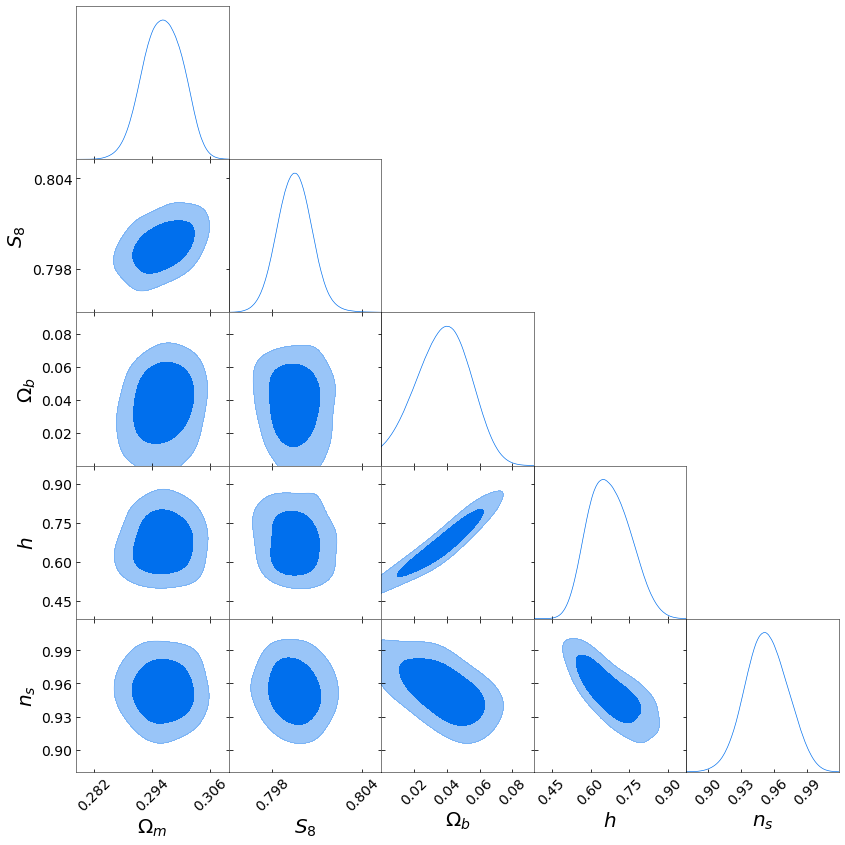

Saving simulators/cosmic_shear/results/mdnseq_train_loss.pdf


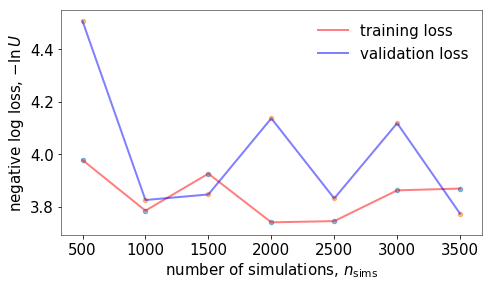

Population 7/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 3.8377, Val_loss: 3.8956
Epoch 00001, Train_loss: 3.8413, Val_loss: 3.9110
Epoch 00002, Train_loss: 3.8421, Val_loss: 3.9145
Epoch 00003, Train_loss: 3.8251, Val_loss: 3.8964
Epoch 00004, Train_loss: 3.8328, Val_loss: 3.9057
Epoch 00005, Train_loss: 3.8467, Val_loss: 3.9318
Epoch 00006, Train_loss: 3.8190, Val_loss: 3.8989
Epoch 00007, Train_loss: 3.8292, Val_loss: 3.9184
Epoch 00008, Train_loss: 3.8248, Val_loss: 3.9077
Epoch 00009, Train_loss: 3.8199, Val_loss: 3.9047
Epoch 00010, Train_loss: 3.8177, Val_loss: 3.9033
Training finished
Best epoch 00009, Val_loss: 3.8956
INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/mdntmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results/mdnseq_train_post_7.pdf


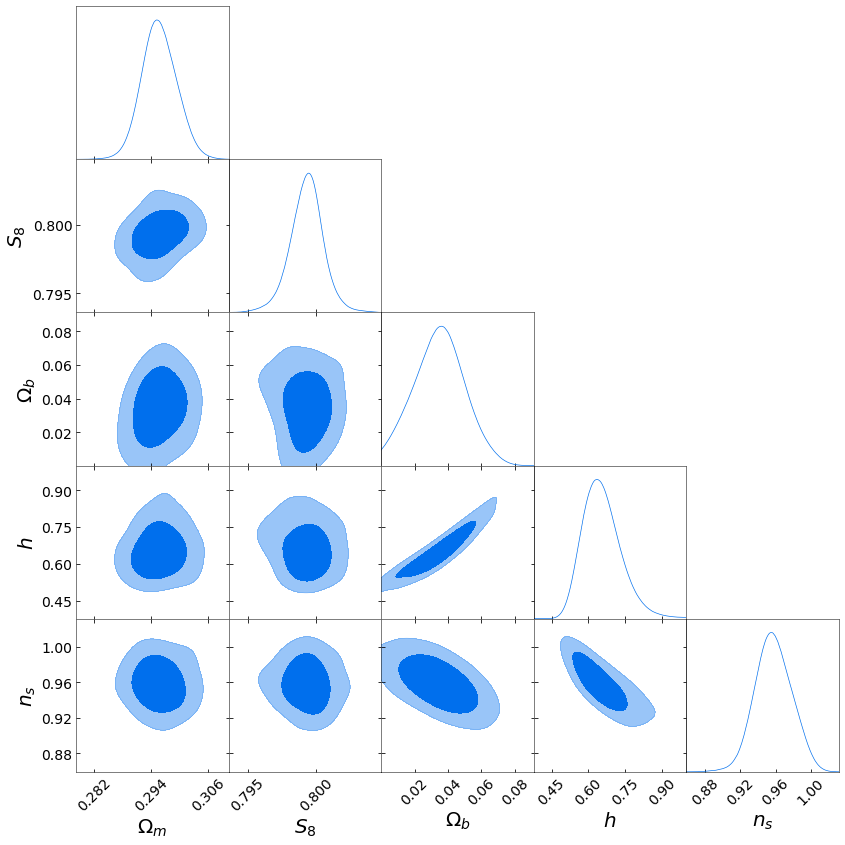

Saving simulators/cosmic_shear/results/mdnseq_train_loss.pdf


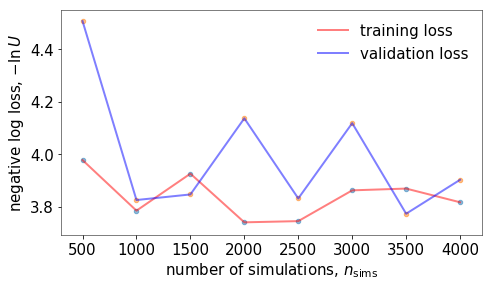

Population 8/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 3.8458, Val_loss: 3.8041
Epoch 00001, Train_loss: 3.8406, Val_loss: 3.8171
Epoch 00002, Train_loss: 3.8383, Val_loss: 3.8145
Epoch 00003, Train_loss: 3.8371, Val_loss: 3.8271
Epoch 00004, Train_loss: 3.8253, Val_loss: 3.8056
Epoch 00005, Train_loss: 3.8171, Val_loss: 3.8006
Epoch 00006, Train_loss: 3.8345, Val_loss: 3.8300
Epoch 00007, Train_loss: 3.8208, Val_loss: 3.8096
Epoch 00008, Train_loss: 3.8154, Val_loss: 3.8070
Epoch 00009, Train_loss: 3.8203, Val_loss: 3.8234
Epoch 00010, Train_loss: 3.8075, Val_loss: 3.8005
Epoch 00011, Train_loss: 3.8085, Val_loss: 3.8008
Epoch 00012, Train_loss: 3.8008, Val_loss: 3.8036
Epoch 00013, Train_loss: 3.8033, Val_loss: 3.7918
Epoch 00014, Train_loss: 3.8052, Val_loss: 3.8142
Epoch 00015, Train_loss: 3.7961, Val_loss: 3.7961
Epoch 00016, Train_loss: 3.8005, Val_loss: 3.7969
Epoch 00017, Train_loss: 3.7944, Val_loss: 3.8010
Epoch 00018, Train_loss

INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/mdntmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results/mdnseq_train_post_8.pdf


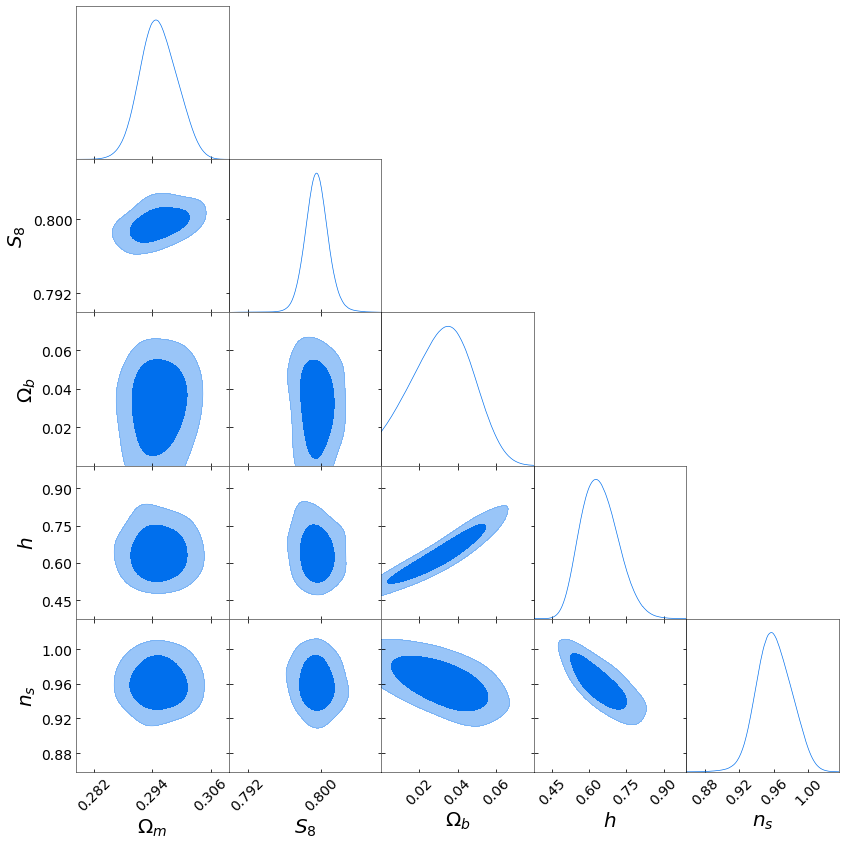

Saving simulators/cosmic_shear/results/mdnseq_train_loss.pdf


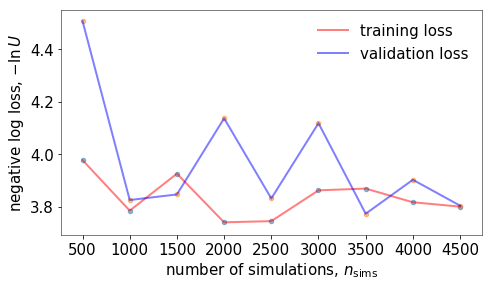

Population 9/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 3.7838, Val_loss: 3.7709
Epoch 00001, Train_loss: 3.7842, Val_loss: 3.7854
Epoch 00002, Train_loss: 3.7777, Val_loss: 3.7719
Epoch 00003, Train_loss: 3.7772, Val_loss: 3.7696
Epoch 00004, Train_loss: 3.7761, Val_loss: 3.7866
Epoch 00005, Train_loss: 3.7806, Val_loss: 3.7748
Epoch 00006, Train_loss: 3.7792, Val_loss: 3.7859
Epoch 00007, Train_loss: 3.7787, Val_loss: 3.7955
Epoch 00008, Train_loss: 3.7670, Val_loss: 3.7733
Epoch 00009, Train_loss: 3.7681, Val_loss: 3.7793
Epoch 00010, Train_loss: 3.7864, Val_loss: 3.8086
Epoch 00011, Train_loss: 3.7671, Val_loss: 3.7707
Epoch 00012, Train_loss: 3.7638, Val_loss: 3.7888
Epoch 00013, Train_loss: 3.7615, Val_loss: 3.7742
Training finished
Best epoch 00012, Val_loss: 3.7696
INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/mdntmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results/mdnseq_train_post_9.pdf


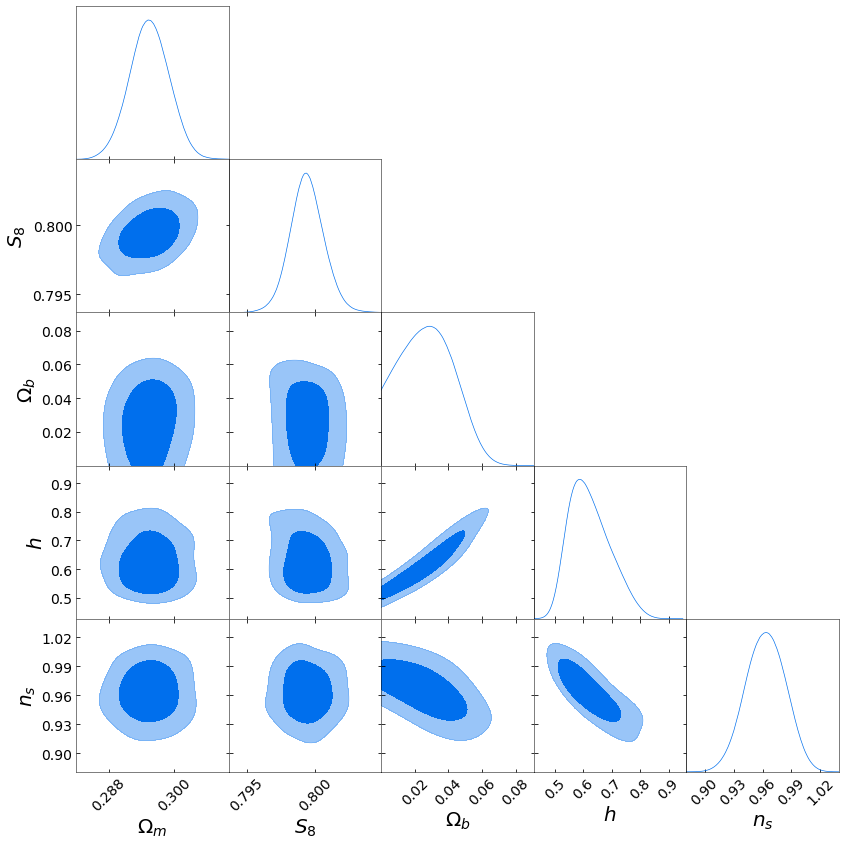

Saving simulators/cosmic_shear/results/mdnseq_train_loss.pdf


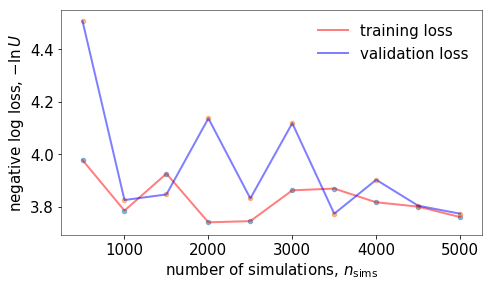

Population 10/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 3.7694, Val_loss: 3.7307
Epoch 00001, Train_loss: 3.7722, Val_loss: 3.7409
Epoch 00002, Train_loss: 3.7704, Val_loss: 3.7357
Epoch 00003, Train_loss: 3.7653, Val_loss: 3.7328
Epoch 00004, Train_loss: 3.7716, Val_loss: 3.7548
Epoch 00005, Train_loss: 3.7707, Val_loss: 3.7358
Epoch 00006, Train_loss: 3.7575, Val_loss: 3.7376
Epoch 00007, Train_loss: 3.7572, Val_loss: 3.7274
Epoch 00008, Train_loss: 3.7567, Val_loss: 3.7374
Epoch 00009, Train_loss: 3.7524, Val_loss: 3.7371
Epoch 00010, Train_loss: 3.7549, Val_loss: 3.7295
Epoch 00011, Train_loss: 3.7491, Val_loss: 3.7225
Epoch 00012, Train_loss: 3.7503, Val_loss: 3.7348
Epoch 00013, Train_loss: 3.7658, Val_loss: 3.7561
Epoch 00014, Train_loss: 3.7495, Val_loss: 3.7363
Epoch 00015, Train_loss: 3.7619, Val_loss: 3.7360
Epoch 00016, Train_loss: 3.7561, Val_loss: 3.7516
Epoch 00017, Train_loss: 3.7426, Val_loss: 3.7264
Epoch 00018, Train_los

INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/mdntmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results/mdnseq_train_post_10.pdf


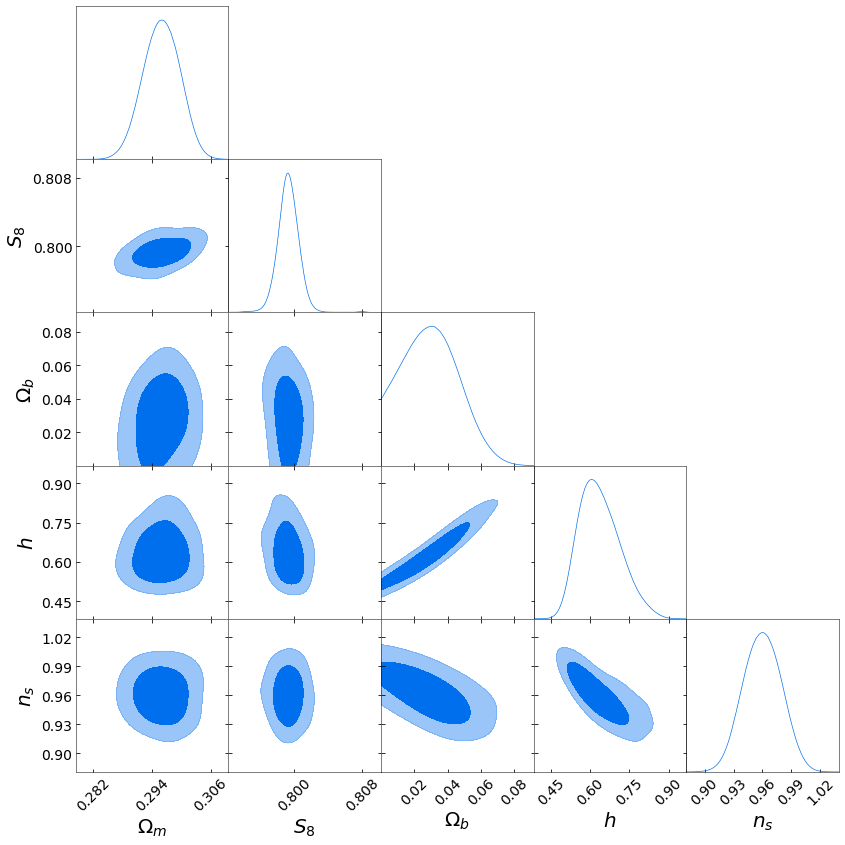

Saving simulators/cosmic_shear/results/mdnseq_train_loss.pdf


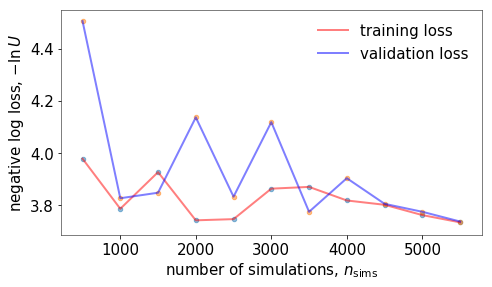

Population 11/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 3.7192, Val_loss: 3.7721
Epoch 00001, Train_loss: 3.7238, Val_loss: 3.7868
Epoch 00002, Train_loss: 3.7133, Val_loss: 3.7742
Epoch 00003, Train_loss: 3.7192, Val_loss: 3.7772
Epoch 00004, Train_loss: 3.7145, Val_loss: 3.7837
Epoch 00005, Train_loss: 3.7259, Val_loss: 3.8016
Epoch 00006, Train_loss: 3.7098, Val_loss: 3.7766
Epoch 00007, Train_loss: 3.7155, Val_loss: 3.7869
Epoch 00008, Train_loss: 3.7128, Val_loss: 3.7793
Epoch 00009, Train_loss: 3.7215, Val_loss: 3.8024
Epoch 00010, Train_loss: 3.7190, Val_loss: 3.7871
Training finished
Best epoch 00009, Val_loss: 3.7721
INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/mdntmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results/mdnseq_train_post_11.pdf


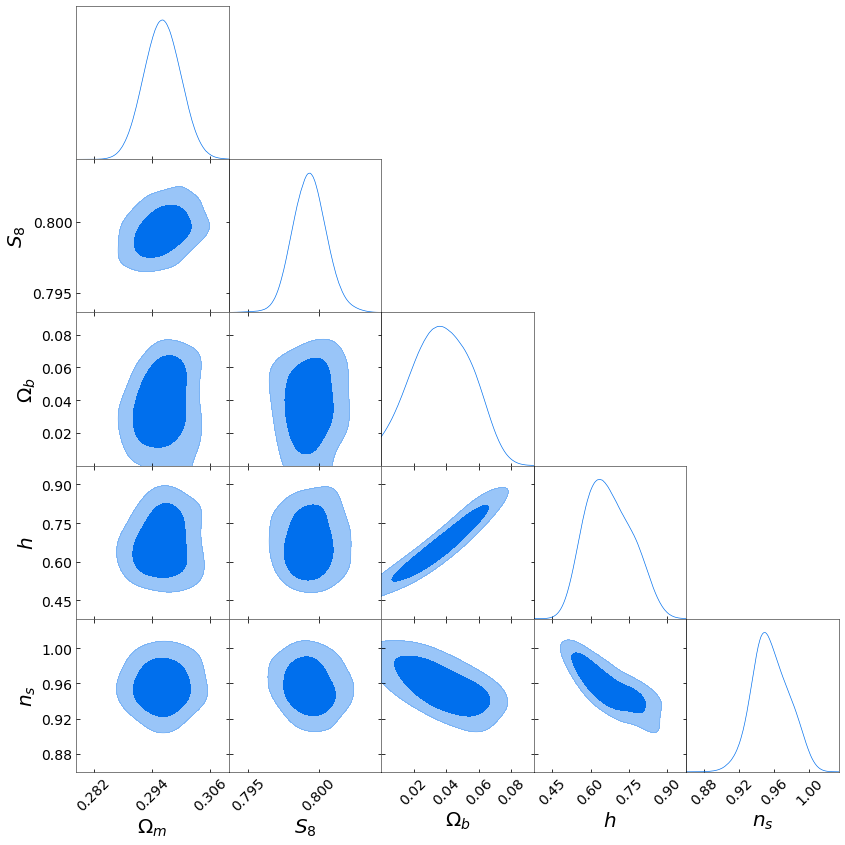

Saving simulators/cosmic_shear/results/mdnseq_train_loss.pdf


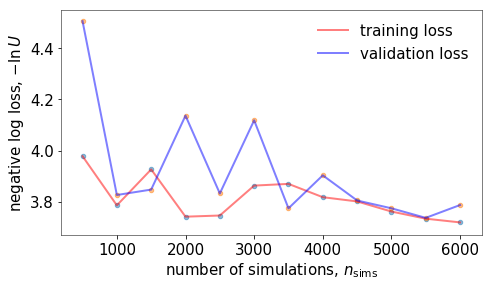

Population 12/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 3.7311, Val_loss: 3.7052
Epoch 00001, Train_loss: 3.7180, Val_loss: 3.6888
Epoch 00002, Train_loss: 3.7202, Val_loss: 3.7031
Epoch 00003, Train_loss: 3.7216, Val_loss: 3.7021
Epoch 00004, Train_loss: 3.7322, Val_loss: 3.7144
Epoch 00005, Train_loss: 3.7182, Val_loss: 3.6922
Epoch 00006, Train_loss: 3.7289, Val_loss: 3.7196
Epoch 00007, Train_loss: 3.7103, Val_loss: 3.6939
Epoch 00008, Train_loss: 3.7132, Val_loss: 3.6962
Epoch 00009, Train_loss: 3.7051, Val_loss: 3.6860
Epoch 00010, Train_loss: 3.7094, Val_loss: 3.7012
Epoch 00011, Train_loss: 3.7094, Val_loss: 3.6977
Epoch 00012, Train_loss: 3.7023, Val_loss: 3.6877
Epoch 00013, Train_loss: 3.7042, Val_loss: 3.6949
Epoch 00014, Train_loss: 3.7085, Val_loss: 3.7019
Epoch 00015, Train_loss: 3.7127, Val_loss: 3.6892
Epoch 00016, Train_loss: 3.6985, Val_loss: 3.6854
Epoch 00017, Train_loss: 3.6971, Val_loss: 3.6895
Epoch 00018, Train_los

INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/mdntmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results/mdnseq_train_post_12.pdf


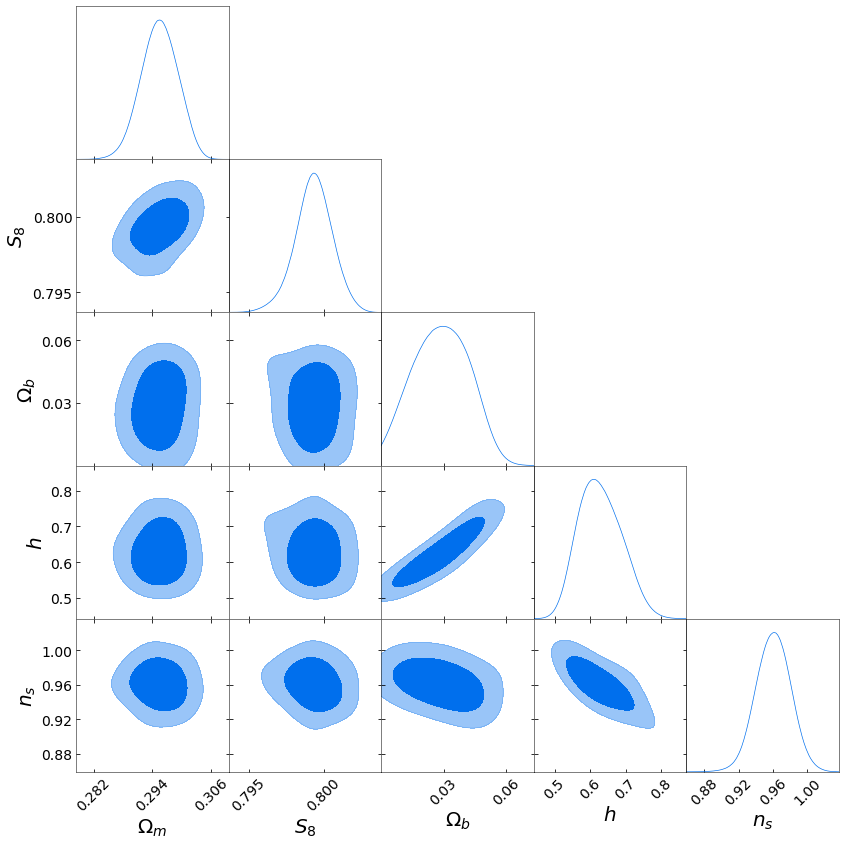

Saving simulators/cosmic_shear/results/mdnseq_train_loss.pdf


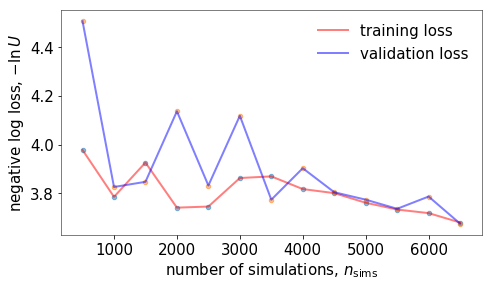

Population 13/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 3.6823, Val_loss: 3.6810
Epoch 00001, Train_loss: 3.7032, Val_loss: 3.6896
Epoch 00002, Train_loss: 3.6767, Val_loss: 3.6819
Epoch 00003, Train_loss: 3.6906, Val_loss: 3.6856
Epoch 00004, Train_loss: 3.6817, Val_loss: 3.6834
Epoch 00005, Train_loss: 3.6740, Val_loss: 3.6826
Epoch 00006, Train_loss: 3.6737, Val_loss: 3.6833
Epoch 00007, Train_loss: 3.6701, Val_loss: 3.6766
Epoch 00008, Train_loss: 3.7046, Val_loss: 3.7392
Epoch 00009, Train_loss: 3.6851, Val_loss: 3.7143
Epoch 00010, Train_loss: 3.6762, Val_loss: 3.7000
Epoch 00011, Train_loss: 3.6688, Val_loss: 3.6933
Epoch 00012, Train_loss: 3.6796, Val_loss: 3.6837
Epoch 00013, Train_loss: 3.6670, Val_loss: 3.6761
Epoch 00014, Train_loss: 3.6719, Val_loss: 3.6906
Epoch 00015, Train_loss: 3.6817, Val_loss: 3.6965
Epoch 00016, Train_loss: 3.6646, Val_loss: 3.6752
Epoch 00017, Train_loss: 3.6675, Val_loss: 3.6927
Epoch 00018, Train_los

INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/mdntmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results/mdnseq_train_post_13.pdf


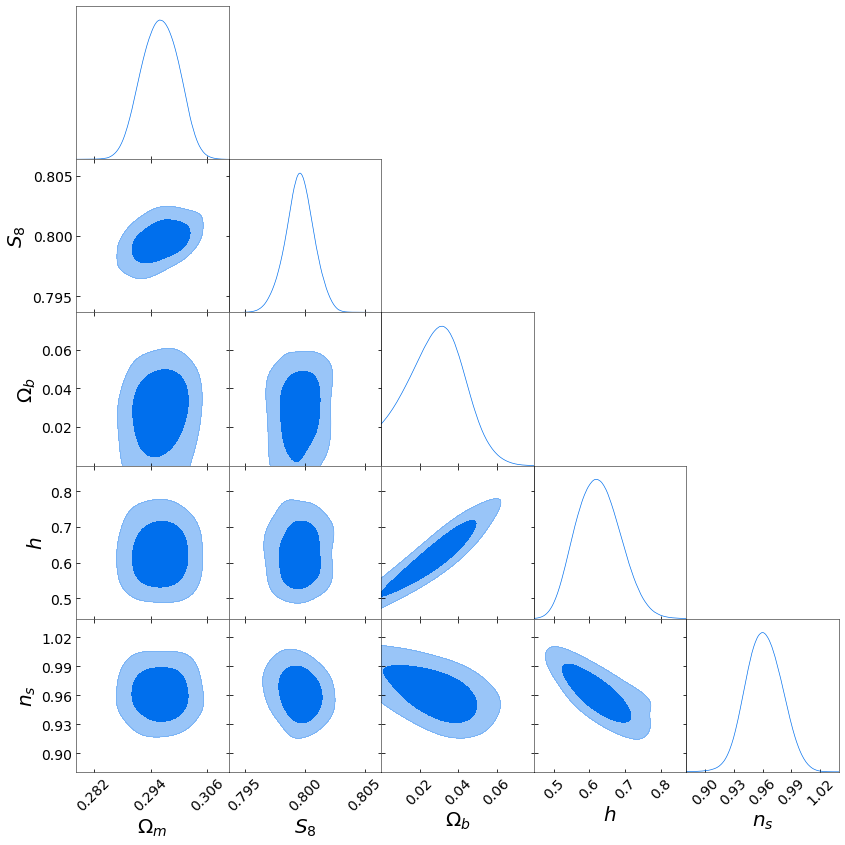

Saving simulators/cosmic_shear/results/mdnseq_train_loss.pdf


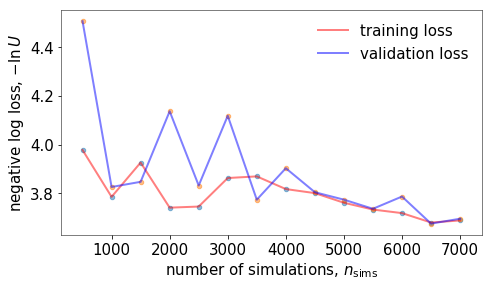

Population 14/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 3.6655, Val_loss: 3.5590
Epoch 00001, Train_loss: 3.6752, Val_loss: 3.5794
Epoch 00002, Train_loss: 3.6871, Val_loss: 3.5929
Epoch 00003, Train_loss: 3.6595, Val_loss: 3.5638
Epoch 00004, Train_loss: 3.6608, Val_loss: 3.5652
Epoch 00005, Train_loss: 3.6591, Val_loss: 3.5713
Epoch 00006, Train_loss: 3.6625, Val_loss: 3.5754
Epoch 00007, Train_loss: 3.6573, Val_loss: 3.5694
Epoch 00008, Train_loss: 3.6682, Val_loss: 3.5815
Epoch 00009, Train_loss: 3.6565, Val_loss: 3.5692
Epoch 00010, Train_loss: 3.6545, Val_loss: 3.5719
Training finished
Best epoch 00009, Val_loss: 3.5590
INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/mdntmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results/mdnseq_train_post_14.pdf


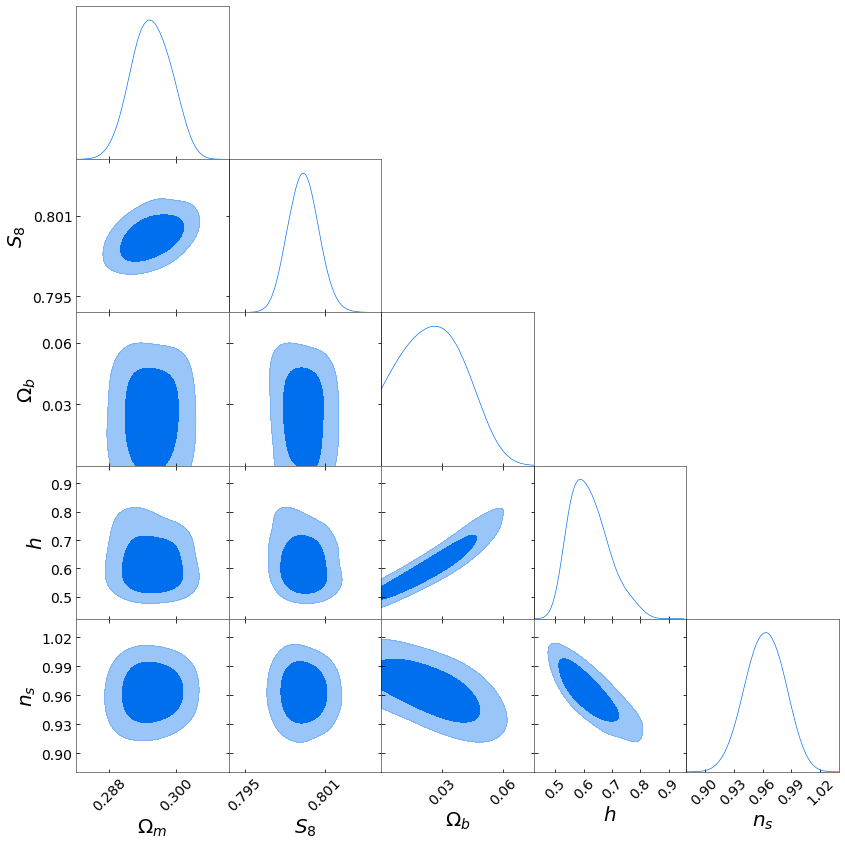

Saving simulators/cosmic_shear/results/mdnseq_train_loss.pdf


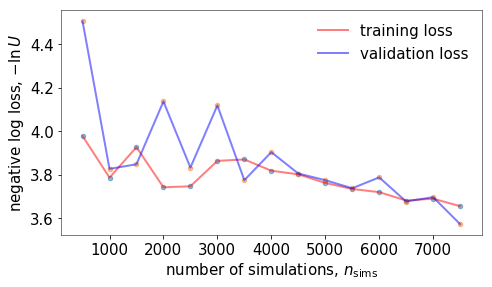

Population 15/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 3.6551, Val_loss: 3.5945
Epoch 00001, Train_loss: 3.6543, Val_loss: 3.5991
Epoch 00002, Train_loss: 3.6535, Val_loss: 3.6050
Epoch 00003, Train_loss: 3.6726, Val_loss: 3.6384
Epoch 00004, Train_loss: 3.6530, Val_loss: 3.6173
Epoch 00005, Train_loss: 3.6625, Val_loss: 3.6305
Epoch 00006, Train_loss: 3.6624, Val_loss: 3.6368
Epoch 00007, Train_loss: 3.6446, Val_loss: 3.6127
Epoch 00008, Train_loss: 3.6564, Val_loss: 3.6143
Epoch 00009, Train_loss: 3.6432, Val_loss: 3.6094
Epoch 00010, Train_loss: 3.6423, Val_loss: 3.6041
Training finished
Best epoch 00009, Val_loss: 3.5945
INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/mdntmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results/mdnseq_train_post_15.pdf


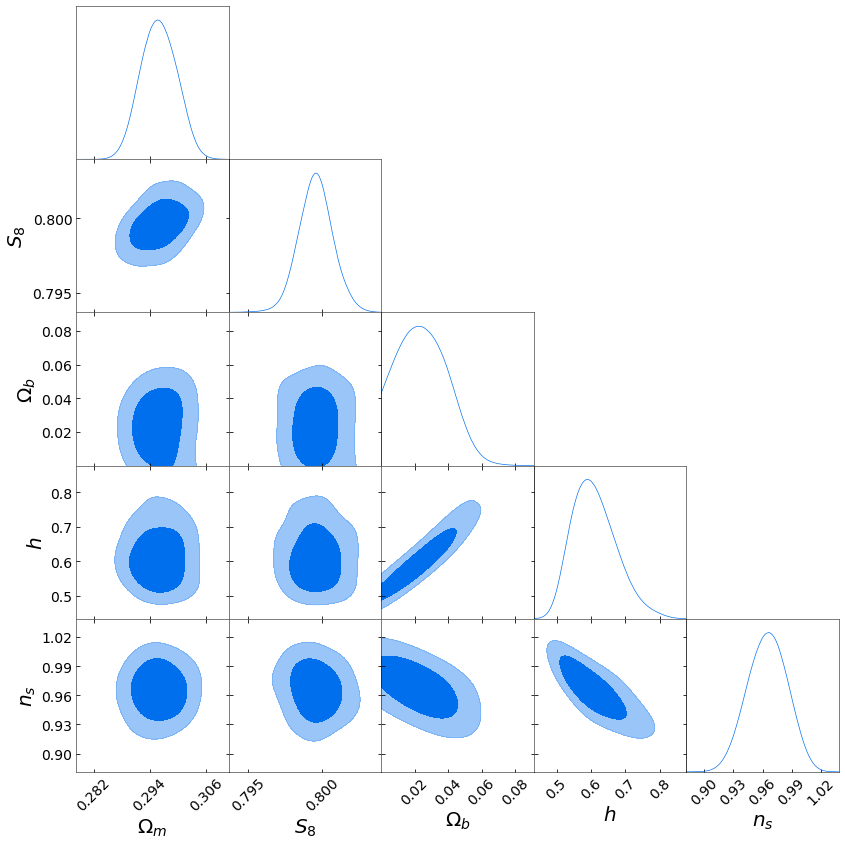

Saving simulators/cosmic_shear/results/mdnseq_train_loss.pdf


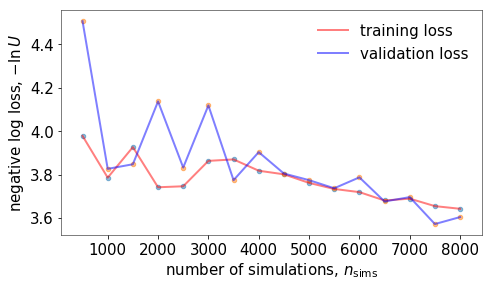

Population 16/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 3.6551, Val_loss: 3.5761
Epoch 00001, Train_loss: 3.6754, Val_loss: 3.6077
Epoch 00002, Train_loss: 3.6601, Val_loss: 3.5945
Epoch 00003, Train_loss: 3.6485, Val_loss: 3.5855
Epoch 00004, Train_loss: 3.6654, Val_loss: 3.6089
Epoch 00005, Train_loss: 3.6516, Val_loss: 3.5858
Epoch 00006, Train_loss: 3.6466, Val_loss: 3.5825
Epoch 00007, Train_loss: 3.6419, Val_loss: 3.5802
Epoch 00008, Train_loss: 3.6484, Val_loss: 3.5902
Epoch 00009, Train_loss: 3.6420, Val_loss: 3.5841
Epoch 00010, Train_loss: 3.6395, Val_loss: 3.5765
Training finished
Best epoch 00009, Val_loss: 3.5761
INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/mdntmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results/mdnseq_train_post_16.pdf


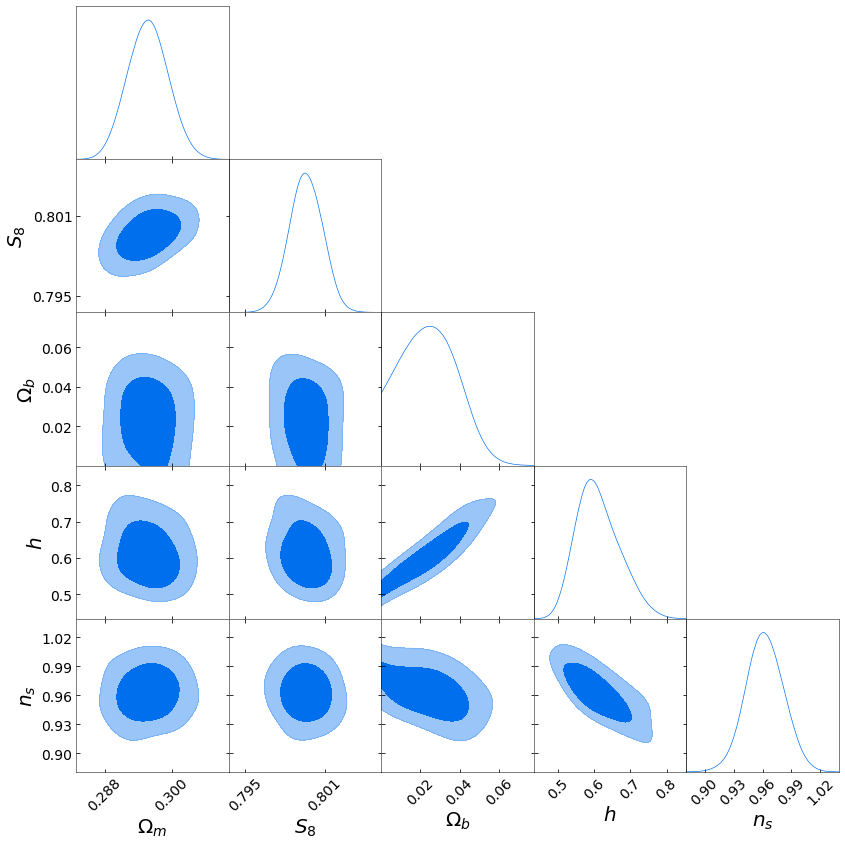

Saving simulators/cosmic_shear/results/mdnseq_train_loss.pdf


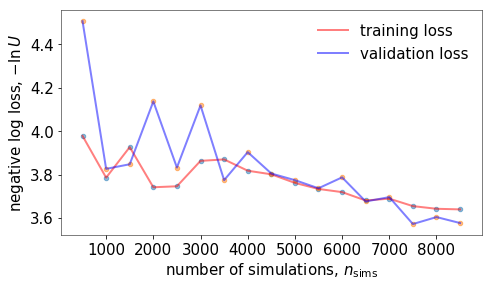

Population 17/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 3.6623, Val_loss: 3.6232
Epoch 00001, Train_loss: 3.6566, Val_loss: 3.6337
Epoch 00002, Train_loss: 3.6569, Val_loss: 3.6352
Epoch 00003, Train_loss: 3.6671, Val_loss: 3.6561
Epoch 00004, Train_loss: 3.6557, Val_loss: 3.6335
Epoch 00005, Train_loss: 3.6491, Val_loss: 3.6191
Epoch 00006, Train_loss: 3.6455, Val_loss: 3.6186
Epoch 00007, Train_loss: 3.6553, Val_loss: 3.6396
Epoch 00008, Train_loss: 3.6498, Val_loss: 3.6286
Epoch 00009, Train_loss: 3.6576, Val_loss: 3.6333
Epoch 00010, Train_loss: 3.6440, Val_loss: 3.6301
Epoch 00011, Train_loss: 3.6463, Val_loss: 3.6298
Epoch 00012, Train_loss: 3.6419, Val_loss: 3.6272
Epoch 00013, Train_loss: 3.6417, Val_loss: 3.6276
Epoch 00014, Train_loss: 3.6741, Val_loss: 3.6647
Epoch 00015, Train_loss: 3.6580, Val_loss: 3.6462
Epoch 00016, Train_loss: 3.6368, Val_loss: 3.6238
Training finished
Best epoch 00015, Val_loss: 3.6186
INFO:tensorflow:Res

INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/mdntmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results/mdnseq_train_post_17.pdf


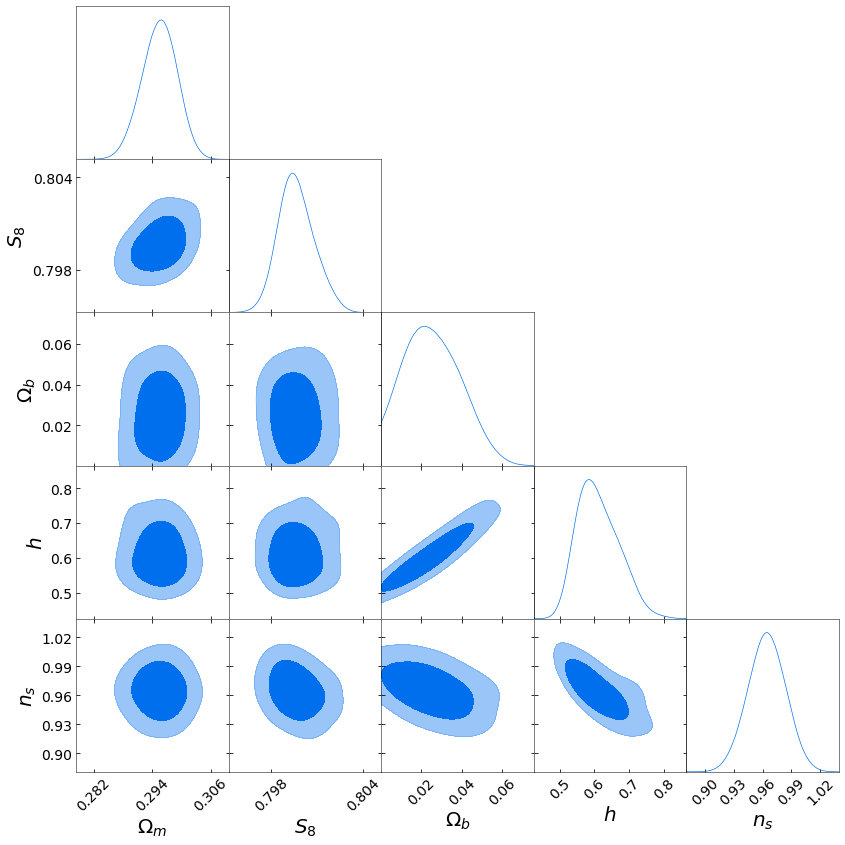

Saving simulators/cosmic_shear/results/mdnseq_train_loss.pdf


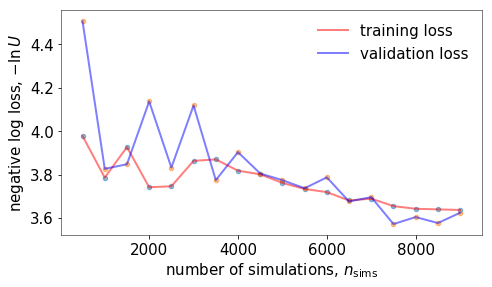

Population 18/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 3.6607, Val_loss: 3.5751
Epoch 00001, Train_loss: 3.6657, Val_loss: 3.5787
Epoch 00002, Train_loss: 3.6766, Val_loss: 3.5779
Epoch 00003, Train_loss: 3.6744, Val_loss: 3.5827
Epoch 00004, Train_loss: 3.6559, Val_loss: 3.5750
Epoch 00005, Train_loss: 3.6557, Val_loss: 3.5744
Epoch 00006, Train_loss: 3.6626, Val_loss: 3.5956
Epoch 00007, Train_loss: 3.6660, Val_loss: 3.5860
Epoch 00008, Train_loss: 3.6571, Val_loss: 3.5718
Epoch 00009, Train_loss: 3.6532, Val_loss: 3.5770
Epoch 00010, Train_loss: 3.6542, Val_loss: 3.5802
Epoch 00011, Train_loss: 3.6573, Val_loss: 3.5827
Epoch 00012, Train_loss: 3.6530, Val_loss: 3.5831
Epoch 00013, Train_loss: 3.6509, Val_loss: 3.5775
Epoch 00014, Train_loss: 3.6578, Val_loss: 3.5723
Epoch 00015, Train_loss: 3.6609, Val_loss: 3.5728
Epoch 00016, Train_loss: 3.6521, Val_loss: 3.5669
Epoch 00017, Train_loss: 3.6514, Val_loss: 3.5686
Epoch 00018, Train_los

INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/mdntmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results/mdnseq_train_post_18.pdf


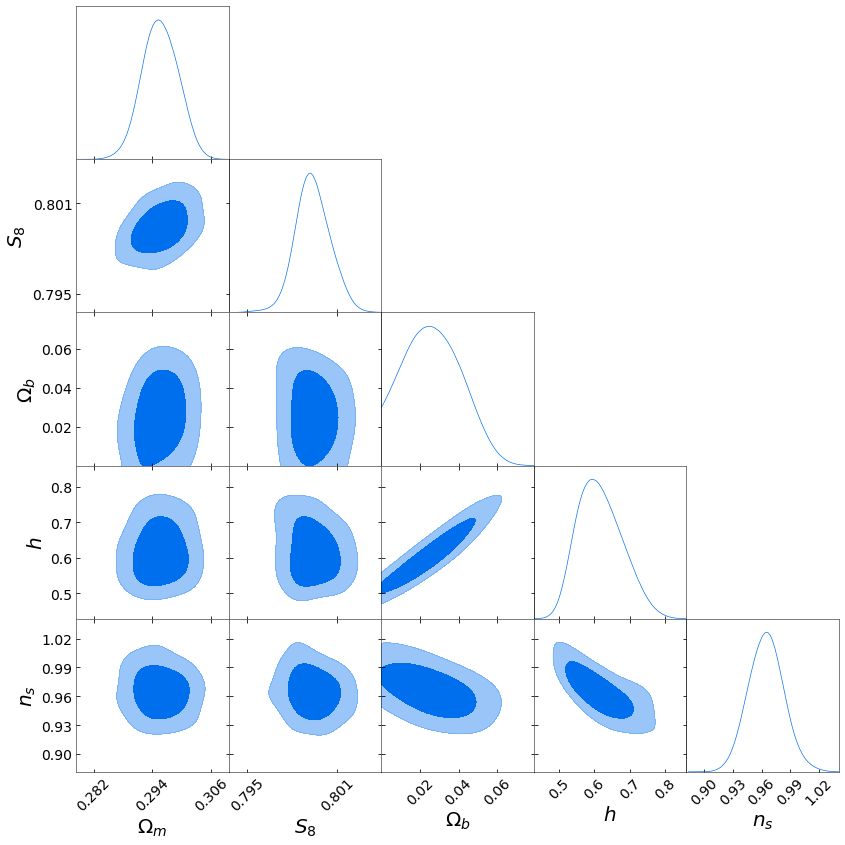

Saving simulators/cosmic_shear/results/mdnseq_train_loss.pdf


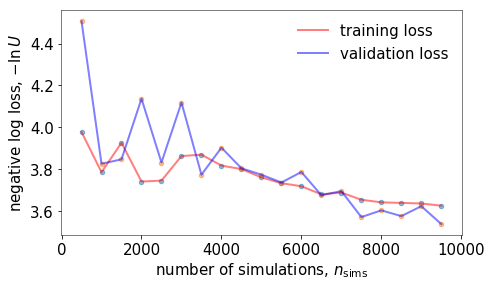

Population 19/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 3.5908, Val_loss: 3.6726
Epoch 00001, Train_loss: 3.5964, Val_loss: 3.6753
Epoch 00002, Train_loss: 3.5960, Val_loss: 3.6800
Epoch 00003, Train_loss: 3.5910, Val_loss: 3.6815
Epoch 00004, Train_loss: 3.6056, Val_loss: 3.7015
Epoch 00005, Train_loss: 3.6156, Val_loss: 3.7040
Epoch 00006, Train_loss: 3.5866, Val_loss: 3.6836
Epoch 00007, Train_loss: 3.5858, Val_loss: 3.6812
Epoch 00008, Train_loss: 3.5976, Val_loss: 3.6874
Epoch 00009, Train_loss: 3.5882, Val_loss: 3.6848
Epoch 00010, Train_loss: 3.6029, Val_loss: 3.6973
Training finished
Best epoch 00009, Val_loss: 3.6726
INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/mdntmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results/mdnseq_train_post_19.pdf


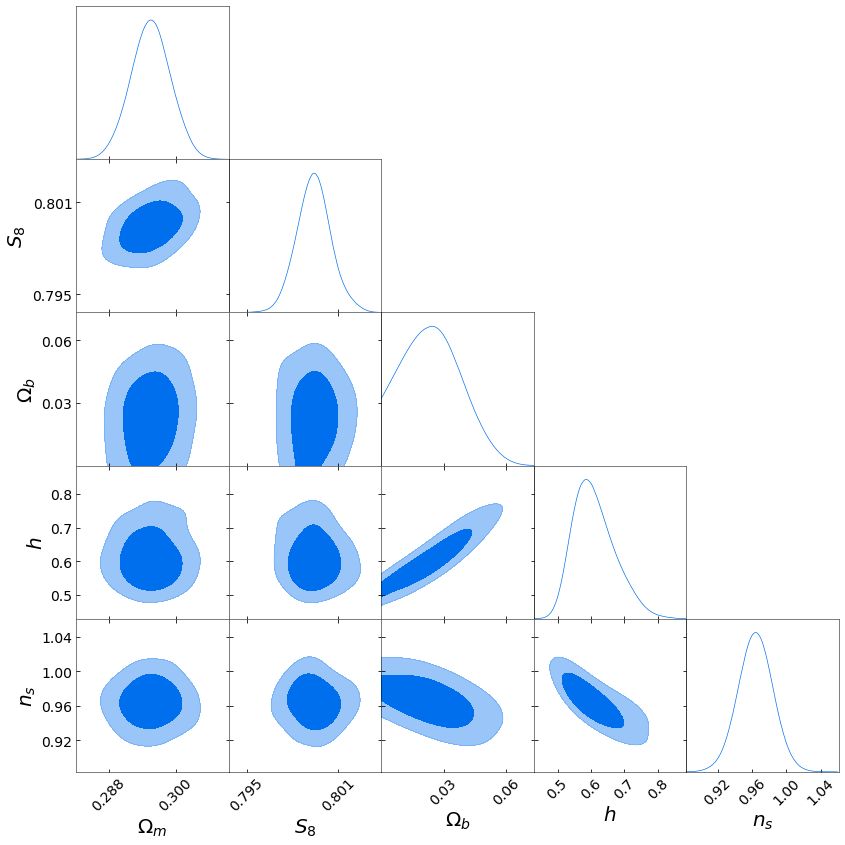

Saving simulators/cosmic_shear/results/mdnseq_train_loss.pdf


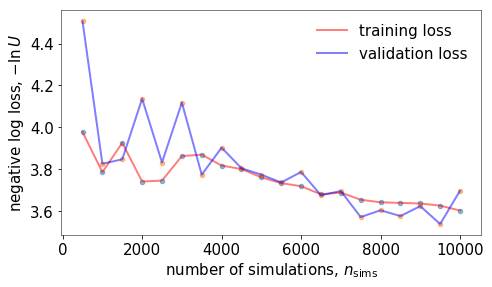

Population 20/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 3.5919, Val_loss: 3.5533
Epoch 00001, Train_loss: 3.6029, Val_loss: 3.5665
Epoch 00002, Train_loss: 3.5954, Val_loss: 3.5602
Epoch 00003, Train_loss: 3.6106, Val_loss: 3.5751
Epoch 00004, Train_loss: 3.5902, Val_loss: 3.5615
Epoch 00005, Train_loss: 3.5970, Val_loss: 3.5686
Epoch 00006, Train_loss: 3.5903, Val_loss: 3.5645
Epoch 00007, Train_loss: 3.6144, Val_loss: 3.5932
Epoch 00008, Train_loss: 3.6059, Val_loss: 3.5825
Epoch 00009, Train_loss: 3.5909, Val_loss: 3.5626
Epoch 00010, Train_loss: 3.5884, Val_loss: 3.5622
Training finished
Best epoch 00009, Val_loss: 3.5533
INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/mdntmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results/mdnseq_train_post_20.pdf


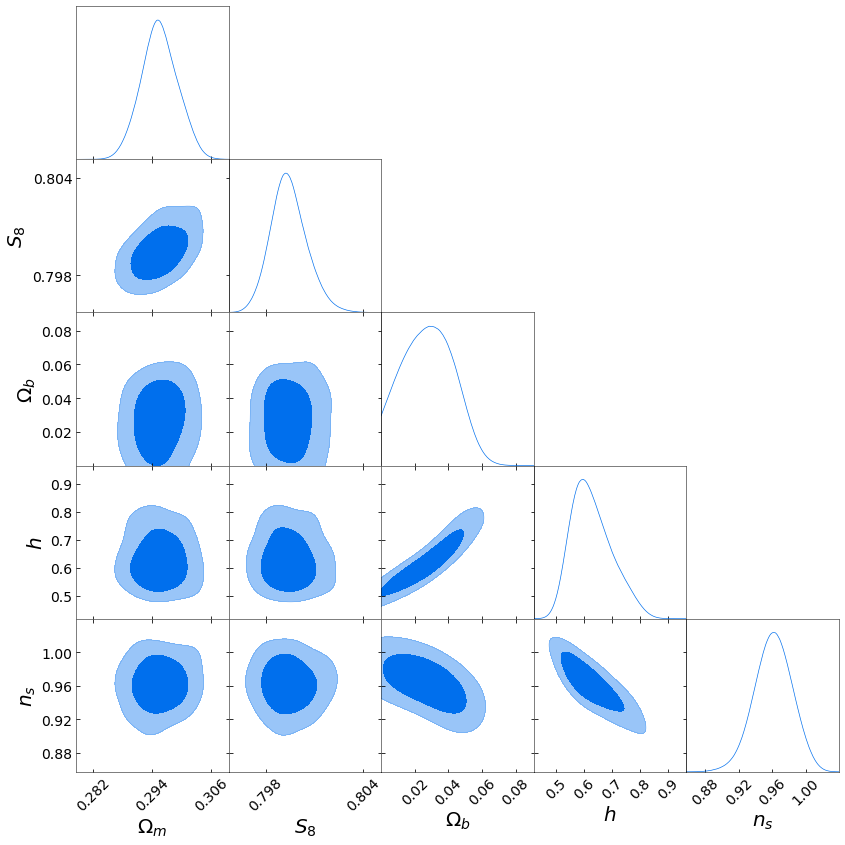

Saving simulators/cosmic_shear/results/mdnseq_train_loss.pdf


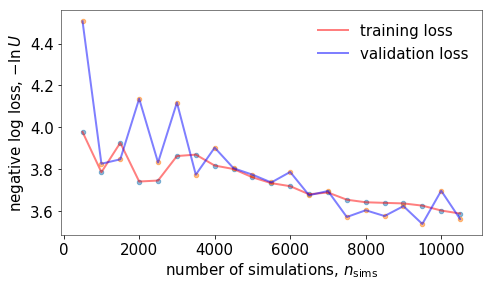

Population 21/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 3.5839, Val_loss: 3.5792
Epoch 00001, Train_loss: 3.6059, Val_loss: 3.5936
Epoch 00002, Train_loss: 3.6082, Val_loss: 3.5959
Epoch 00003, Train_loss: 3.5852, Val_loss: 3.5894
Epoch 00004, Train_loss: 3.5892, Val_loss: 3.5954
Epoch 00005, Train_loss: 3.6041, Val_loss: 3.6184
Epoch 00006, Train_loss: 3.5816, Val_loss: 3.5879
Epoch 00007, Train_loss: 3.5908, Val_loss: 3.5880
Epoch 00008, Train_loss: 3.6433, Val_loss: 3.6344
Epoch 00009, Train_loss: 3.5869, Val_loss: 3.5862
Epoch 00010, Train_loss: 3.5959, Val_loss: 3.6103
Training finished
Best epoch 00009, Val_loss: 3.5792
INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/mdntmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results/mdnseq_train_post_21.pdf


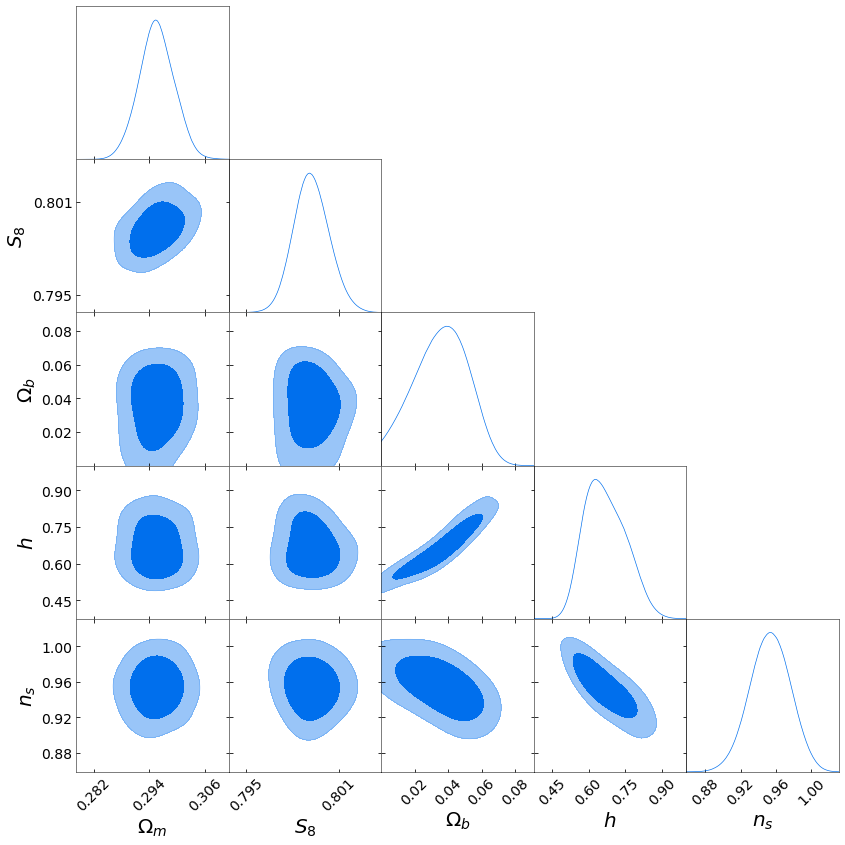

Saving simulators/cosmic_shear/results/mdnseq_train_loss.pdf


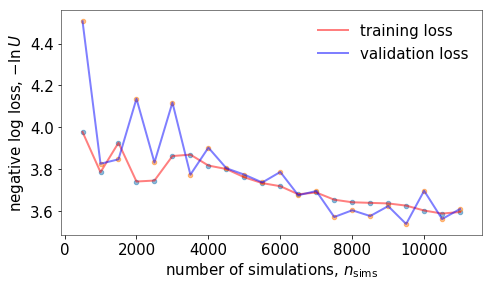

Population 22/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 3.6446, Val_loss: 3.5955
Epoch 00001, Train_loss: 3.6126, Val_loss: 3.5625
Epoch 00002, Train_loss: 3.5874, Val_loss: 3.5418
Epoch 00003, Train_loss: 3.5957, Val_loss: 3.5531
Epoch 00004, Train_loss: 3.5880, Val_loss: 3.5458
Epoch 00005, Train_loss: 3.5921, Val_loss: 3.5519
Epoch 00006, Train_loss: 3.5921, Val_loss: 3.5480
Epoch 00007, Train_loss: 3.5946, Val_loss: 3.5526
Epoch 00008, Train_loss: 3.5835, Val_loss: 3.5471
Epoch 00009, Train_loss: 3.5878, Val_loss: 3.5479
Epoch 00010, Train_loss: 3.5855, Val_loss: 3.5488
Epoch 00011, Train_loss: 3.5827, Val_loss: 3.5455
Epoch 00012, Train_loss: 3.5793, Val_loss: 3.5370
Epoch 00013, Train_loss: 3.5793, Val_loss: 3.5426
Epoch 00014, Train_loss: 3.5794, Val_loss: 3.5390
Epoch 00015, Train_loss: 3.5937, Val_loss: 3.5590
Epoch 00016, Train_loss: 3.5823, Val_loss: 3.5483
Epoch 00017, Train_loss: 3.5763, Val_loss: 3.5383
Epoch 00018, Train_los

INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/mdntmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results/mdnseq_train_post_22.pdf


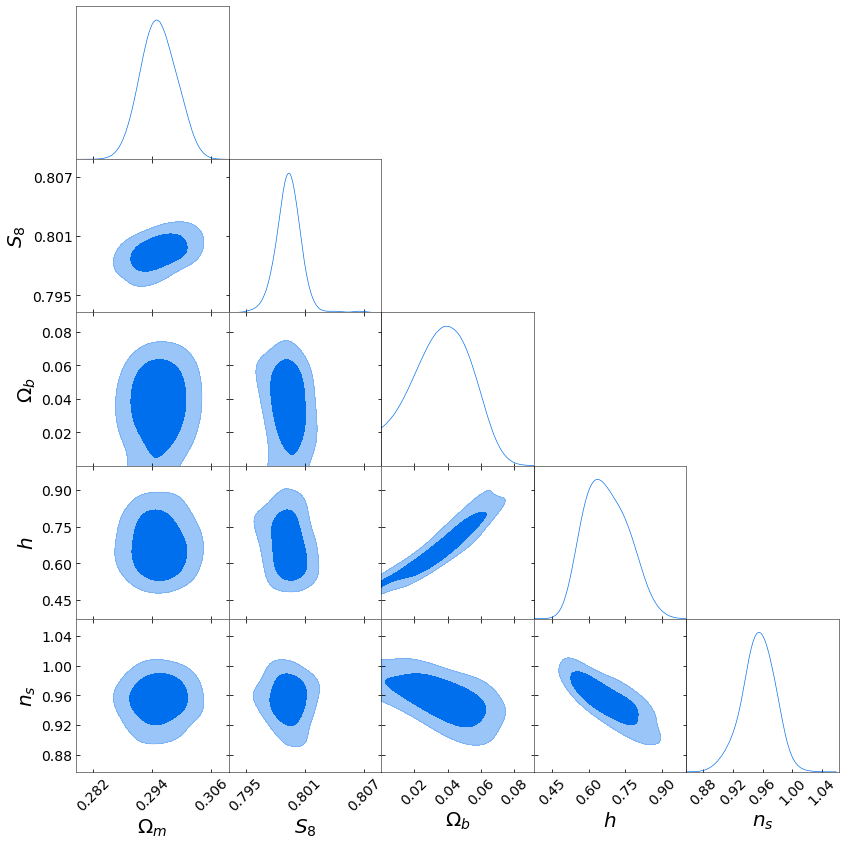

Saving simulators/cosmic_shear/results/mdnseq_train_loss.pdf


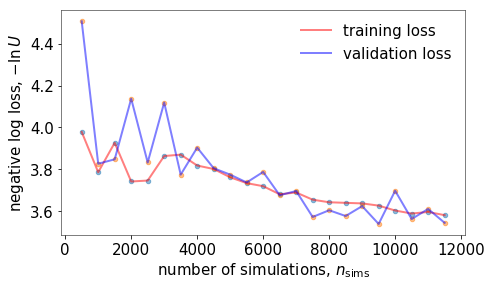

Population 23/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 3.5763, Val_loss: 3.6344
Epoch 00001, Train_loss: 3.5743, Val_loss: 3.6224
Epoch 00002, Train_loss: 3.5735, Val_loss: 3.6314
Epoch 00003, Train_loss: 3.5832, Val_loss: 3.6379
Epoch 00004, Train_loss: 3.5686, Val_loss: 3.6235
Epoch 00005, Train_loss: 3.5785, Val_loss: 3.6367
Epoch 00006, Train_loss: 3.5844, Val_loss: 3.6419
Epoch 00007, Train_loss: 3.5708, Val_loss: 3.6285
Epoch 00008, Train_loss: 3.5811, Val_loss: 3.6468
Epoch 00009, Train_loss: 3.5722, Val_loss: 3.6287
Epoch 00010, Train_loss: 3.5686, Val_loss: 3.6289
Epoch 00011, Train_loss: 3.5711, Val_loss: 3.6379
Training finished
Best epoch 00010, Val_loss: 3.6224
INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/mdntmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results/mdnseq_train_post_23.pdf


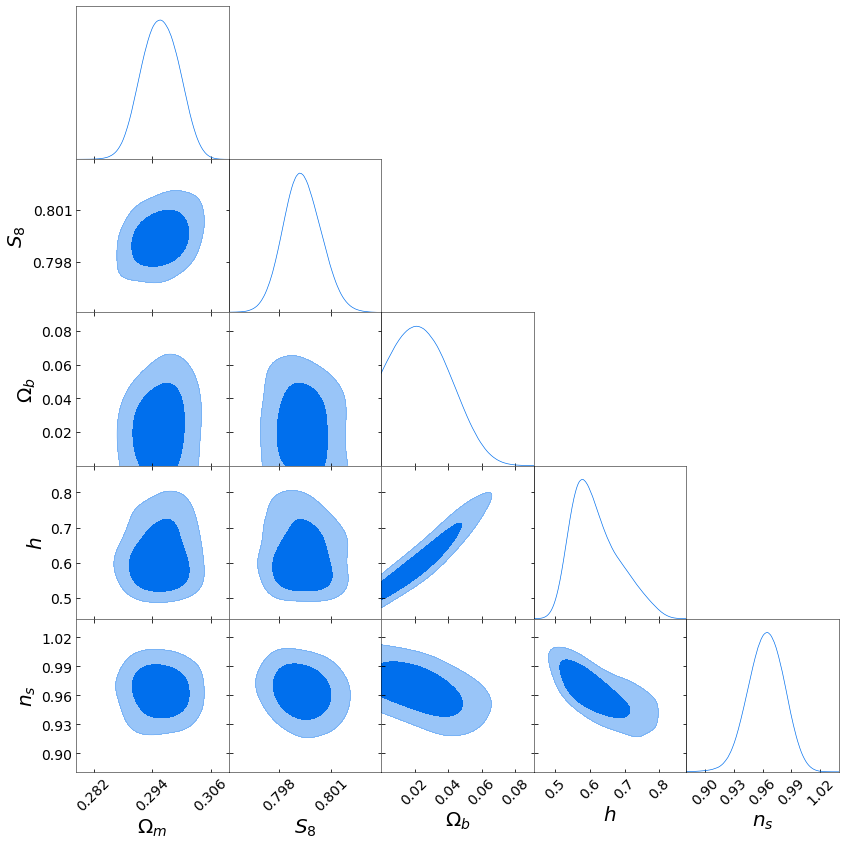

Saving simulators/cosmic_shear/results/mdnseq_train_loss.pdf


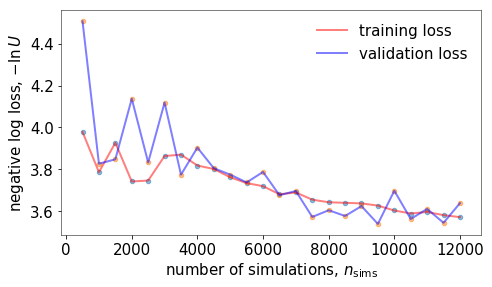

In [11]:
# Initial samples, batch size for population samples, number of populations
n_initial = 500
n_batch = 500
n_populations = 23

# Do the SNL training
DelfiMDN.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=10)